In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update(
    {
        # ── Canvas size & resolution ───────────────────────────────────────────
        # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
        "figure.figsize": (12, 8),
        "figure.dpi": 200,  # crisp in-notebook / retina preview
        "savefig.dpi": 400,  # print-quality PNG/PDF
        # ── Fonts ──────────────────────────────────────────────────────────────
        "font.family": "sans-serif",
        "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
        "axes.titlesize": 24,
        # "axes.titleweight": "bold",
        "axes.labelsize": 24,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 20,
        # ── Axis & spine aesthetics ────────────────────────────────────────────
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.linewidth": 1,
        "axes.grid": True,
        "grid.color": "#E6E6E6",
        "grid.linewidth": 0.4,
        "grid.alpha": 0.8,
        # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
        "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),
        # ── Figure background ─────────────────────────────────────────────────
        "figure.facecolor": "white",
    }
)

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",  # slightly larger fonts for presentations / papers
    style="whitegrid",  # grid only on y-axis (good for histograms)
    palette="Set2",  # matches the rcParams colour cycle
)


# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=True, **savefig_kwargs)


# 4.  Colour constants for this project (optional convenience)
COL_RAW = "#1f77b4"  # e.g. unweighted sample
COL_WEIGHTED = "#d62728"  # weighted sample
COL_REF = "0.35"  # census reference (neutral grey)

In [3]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
AGE_DATA_DIR = Path("/home/galkepler/Projects/neuroaging/data")
DATA_DIR = Path("/home/galkepler/Projects/athletes_brain/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/athletes_brain/figures/fig3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" / "atlases" / ATLAS / "parcels.csv", index_col=0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [77]:
metrics = ["gm_vol", "adc", "fa", "ad", "rd"]
distribution_metric = "qfmean"

bad_subjects = ["IN120120"]

# Load the data
data = {}

demo = pd.read_csv(DATA_DIR / "processed" / f"{metrics[0]}.csv", index_col=0)
target_subjects = demo[demo["target"]]["subject_code"].unique()


/tmp/ipykernel_1164913/1642339077.py:9: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  demo = pd.read_csv(DATA_DIR / "processed" / f"{metrics[0]}.csv", index_col=0)


In [5]:
for metric in metrics:
    data[metric] = pd.read_csv(AGE_DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
        drop=True
    )
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})
    data[metric]["target"] = False
    data[metric].loc[data[metric]["subject_code"].isin(target_subjects), "target"] = True
    


# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_1164913/142817988.py:2: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(AGE_DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_1164913/142817988.py:2: DtypeWarning: Columns (16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(AGE_DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_1164913/142817988.py:2: DtypeWarning: Columns (16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(AGE_DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_1164913/142817988.py:2: DtypeWarning: Columns (16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(AGE_DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_1164913/142

In [6]:
metric_cols = {
    metric: "volume" if metric == "gm_vol" else distribution_metric for metric in metrics
}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df

In [7]:
# assign weights
for metric in metrics:
    data[metric]["subject_code"] = data[metric]["subject_code"].astype(str).str.zfill(4)

In [9]:
import pandas as pd
from functools import reduce


def long_to_wide(
    long_df,
    *,
    index="session_id",  # or "subject_code"
    columns=region_col,
    values="value",
):
    """Pivot a long metric table → wide DataFrame (subjects × regions)."""
    wide = long_df.pivot_table(index=index, columns=columns, values=values, aggfunc="first")
    # Optional: drop regions with >20 % missing values
    thresh = int(0.8 * len(wide))
    wide = wide.dropna(axis=1, thresh=thresh)
    # Optional: drop subejcts with >20 % missing values
    thresh = int(0.8 * len(parcels))
    wide = wide.dropna(axis=0, thresh=thresh)
    # drop duplicate index
    wide = wide.loc[~wide.index.duplicated(keep="first")]
    return wide


def prep_metric_matrices(metric_dict, *, index="subject_code"):
    """
    Parameters
    ----------
    metric_dict : {metric_name: long_df}
        Each DataFrame must include `subject_id`, `region`, `value`,
        `age_at_scan`, and any covariates you want.
    Returns
    -------
    X_dict : {metric_name: ndarray}
             Wide feature matrices aligned on the *intersection* of subjects.
    y, w, cov_df : Series / ndarray
             Age, weights, and any extra covariates for the same subjects.
    """
    # 1.  Convert every long → wide
    wide_dict = {m: long_to_wide(df) for m, df in metric_dict.items()}

    # 2.  Intersect subject index across all metrics
    common_subs = reduce(pd.Index.intersection, [w.index for w in wide_dict.values()])

    # 3.  Slice & order every matrix
    for m in wide_dict:
        wide_dict[m] = wide_dict[m].loc[common_subs]

    # 4.  Pull y, w, covariates from *any* of the long dfs (they all duplicate)
    ref_long = next(iter(metric_dict.values()))
    ref_meta = (
        ref_long.drop_duplicates(subset=["subject_code","session_id"])  # one row per subject
        .set_index("session_id")
        .loc[common_subs]
    )
    # drop duplicate index
    ref_meta = ref_meta.loc[~ref_meta.index.duplicated(keep="first")]
    y = ref_meta["age_at_scan"]
    w = ref_meta.get("weight", pd.Series(1.0, index=common_subs))
    cov = ref_meta[ref_meta.columns.difference(["age_at_scan", "weight"])]


    # 5.  Convert features to numpy (sklearn ready)
    X_dict = {m: wide.to_numpy() for m, wide in wide_dict.items()}
    return X_dict, y.to_numpy(), w.to_numpy(), cov

In [10]:
# -------------------------------------------------------
# Build (X, y, w, cov) once, re-use in every metric loop
# -------------------------------------------------------
X_dict, y, w, cov = prep_metric_matrices(data)
# Example list of covariates you want to *keep* (z-scored later if needed)
cov_names = {
    m: ["sex"] if m != "gm_vol" else ["sex", "tiv"] for m in metrics
}  # e.g. ["sex", "tiv"]

In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Union
from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


def cross_val_predict_with_posthoc(
    model: BaseEstimator,
    X: Union[np.ndarray, pd.DataFrame],
    y: np.ndarray,
    w: np.ndarray,
    cv: BaseCrossValidator,
    *,
    use_weights: bool = True,
    post_hoc_degree: int = 1,
) -> np.ndarray:
    """
    Cross-validated predictions with OPTIONAL linear / polynomial
    post-hoc bias-correction (fit on training residuals only).

    Parameters
    ----------
    model            : any scikit-learn regressor or pipeline
    X                : shape (n_samples, n_features)
    y                : shape (n_samples,) – chronological age
    w                : sample weights, shape (n_samples,)
    cv               : cross-validator providing (train_idx, test_idx)
    use_weights      : if False, sample weights are ignored
    post_hoc_degree  : 0 ⇒ no correction; 1 ⇒ linear; 2 ⇒ quadratic …

    Returns
    -------
    y_pred_corr      : bias-corrected out-of-fold predictions
    """

    # ensure array-like indexing works
    X_arr = X.values if isinstance(X, pd.DataFrame) else X
    y = np.asarray(y)
    w = np.asarray(w)

    y_oof = np.full_like(y, np.nan, dtype=float)

    original_residuals = np.full_like(y, np.nan, dtype=float)
    corrected_residuals = np.full_like(y, np.nan, dtype=float)

    for all_train_idx, test_idx in cv.split(X_arr, y):
        train_idx, val_idx = train_test_split(all_train_idx, test_size=0.2, random_state=42)
        X_tr, X_te, X_val = X_arr[train_idx], X_arr[test_idx], X_arr[val_idx]
        y_tr, y_te, y_val = y[train_idx], y[test_idx], y[val_idx]
        w_tr = w[train_idx]
        w_val = w[val_idx]

        # ---------------- fit base model -----------------------------
        fit_kwargs = {"estimator__sample_weight": w_tr} if use_weights else {}
        model.fit(X_tr, y_tr, **fit_kwargs)

        # ---------------- predict on test fold -----------------------
        y_pred_te = model.predict(X_te)
        y_pred_val = model.predict(X_val)
        y_pred_tr = model.predict(X_tr)
        # ---------------- optional post-hoc bias ---------------------
        if post_hoc_degree > 0:
            orig_resid_te = y_te - y_pred_te
            lin = LinearRegression()
            if post_hoc_degree > 1:
                poly = PolynomialFeatures(degree=post_hoc_degree)
                resid_model = Pipeline([("poly", poly), ("lin", lin)])
            else:
                resid_model = Pipeline([("lin", lin)])
            fit_kwargs = {"lin__sample_weight": w_val} if use_weights else {}
            resid_model.fit(y_val.reshape(-1, 1), y_val - y_pred_val)
            # a, b = lin.intercept_, lin.coef_[0]
            # y_pred_te = (y_pred_te - a) / b
            y_pred_te = y_pred_te + resid_model.predict(y_pred_te.reshape(-1, 1))
            original_residuals[test_idx] = orig_resid_te
            corrected_residuals[test_idx] = y_te - y_pred_te
            # resid_tr = y_tr - model.predict(X_tr)
            # coeffs = np.polyfit(y_pred_tr, resid_tr, post_hoc_degree)
            # bias_fn = np.poly1d(coeffs)
            # orig_resid_te = y_te - y_pred_te
            # te_bias = bias_fn(y_pred_te)
            # y_pred_te = y_pred_te + te_bias
            # original_residuals[test_idx] = orig_resid_te
            # corrected_residuals[test_idx] = y_te - y_pred_te

        y_oof[test_idx] = y_pred_te

    return y_oof, original_residuals, corrected_residuals

In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Union
from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator
import statsmodels.api as sm  # Not strictly needed here, LinearRegression is sufficient
from statsmodels.formula.api import ols  # Not strictly needed here
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline  # Make sure this is imported!


def cross_val_predict_with_de_lange_beheshti(
    model: BaseEstimator,
    X: Union[np.ndarray, pd.DataFrame],
    y: np.ndarray,
    w: np.ndarray,
    cv: BaseCrossValidator,
    *,
    use_weights: bool = True,
    # post_hoc_degree is not directly applicable in this exact formulation
    # but could be adapted if you regress y_actual on poly(y_predicted)
) -> np.ndarray:
    """
    Cross-validated predictions with post-hoc de Lange/Beheshti-style
    linear bias-correction (fit on training residuals only).

    Parameters
    ----------
    model            : any scikit-learn regressor or pipeline
    X                : shape (n_samples, n_features)
    y                : shape (n_samples,) – chronological age
    w                : sample weights, shape (n_samples,)
    cv               : cross-validator providing (train_idx, test_idx)
    use_weights      : if False, sample weights are ignored

    Returns
    -------
    y_pred_corr      : bias-corrected out-of-fold predictions
    original_residuals : uncorrected residuals (actual - predicted)
    corrected_residuals : corrected residuals (actual - corrected_predicted)
    """

    # ensure array-like indexing works
    X_arr = X.values if isinstance(X, pd.DataFrame) else X
    y = np.asarray(y)
    w = np.asarray(w)

    y_oof = np.full_like(y, np.nan, dtype=float)
    original_residuals = np.full_like(y, np.nan, dtype=float)
    corrected_residuals = np.full_like(y, np.nan, dtype=float)

    for all_train_idx, test_idx in cv.split(X_arr, y):
        # Nested split for training base model and fitting bias correction
        train_idx, val_idx = train_test_split(all_train_idx, test_size=0.2, random_state=42)
        X_tr, X_te, X_val = X_arr[train_idx], X_arr[test_idx], X_arr[val_idx]
        y_tr, y_te, y_val = y[train_idx], y[test_idx], y[val_idx]
        w_tr = w[train_idx]
        w_val = w[val_idx]

        # ---------------- fit base model -----------------------------
        fit_kwargs = {"sample_weight": w_tr} if use_weights else {}
        # If 'model' is a pipeline, use 'estimator__sample_weight' or appropriate step name
        if isinstance(model, Pipeline):
            fit_kwargs = {model.steps[-1][0] + "__sample_weight": w_tr} if use_weights else {}
        model.fit(X_tr, y_tr, **fit_kwargs)

        # ---------------- predict on test and validation folds -----------------------
        y_pred_te_original = model.predict(X_te)
        y_pred_val = model.predict(X_val)

        # ---------------- Post-hoc de Lange/Beheshti bias correction ---------------
        # Fit a linear model: y_actual = a + b * y_predicted
        bias_corrector = LinearRegression()
        # Reshape y_pred_val for single feature input to LinearRegression
        fit_kwargs_bias = {"sample_weight": w_val} if use_weights else {}
        bias_corrector.fit(y_pred_val.reshape(-1, 1), y_val, **fit_kwargs_bias)

        alpha = bias_corrector.intercept_
        beta = bias_corrector.coef_[0]

        # Apply correction: y_corrected = (y_predicted - alpha) / beta
        # This transforms the predicted age to follow the identity line with actual age
        # on average across the age range.
        if beta != 0:  # Avoid division by zero
            y_pred_te_corrected = (y_pred_te_original - alpha) / beta
        else:  # Fallback if beta is zero (unlikely with real data but for robustness)
            y_pred_te_corrected = y_pred_te_original  # No effective correction

        # Store results
        y_oof[test_idx] = y_pred_te_corrected
        original_residuals[test_idx] = y_te - y_pred_te_original
        corrected_residuals[test_idx] = y_te - y_pred_te_corrected

    return y_oof, original_residuals, corrected_residuals

In [13]:
import numpy as np
import pandas as pd
from typing import Union
from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline  # Make sure this is imported for PolynomialFeatures usage


def cross_val_predict_with_bias_correction(
    model: BaseEstimator,
    X: Union[np.ndarray, pd.DataFrame],
    y_chronological: np.ndarray,  # y in paper's notation
    w: np.ndarray,
    cv: BaseCrossValidator,
    *,
    use_weights: bool = True,
    post_hoc_degree: int = 0,  # 0 = no correction, 1 = linear de Lange/Beheshti, >1 = polynomial residual correction
    groups: Union[np.ndarray, pd.Series] = None  # Optional groups for GroupKFold
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Cross-validated predictions with optional post-hoc bias-correction.

    Parameters
    ----------
    model            : any scikit-learn regressor or pipeline
    X                : shape (n_samples, n_features)
    y_chronological  : shape (n_samples,) – chronological age (y in paper's notation)
    w                : sample weights, shape (n_samples,)
    cv               : cross-validator providing (train_idx, test_idx)
    use_weights      : if False, sample weights are ignored
    post_hoc_degree  : int
                       0 = no bias correction applied.
                       1 = linear de Lange et al. / Beheshti-style correction (fit x=a*y+b, correct (x-b)/a).
                       >1 = polynomial residual correction (fit residuals as poly of predicted_age, add to prediction).

    Returns
    -------
    y_pred_corr      : bias-corrected out-of-fold predictions
    original_residuals : uncorrected residuals (chronological_age - original_predicted_age)
    corrected_residuals : corrected residuals (chronological_age - corrected_predicted_age)
    """

    # Ensure array-like indexing works
    X_arr = X.values if isinstance(X, pd.DataFrame) else X
    y_chronological = np.asarray(y_chronological)
    w = np.asarray(w)

    y_oof_corrected = np.full_like(y_chronological, np.nan, dtype=float)
    original_residuals = np.full_like(y_chronological, np.nan, dtype=float)
    corrected_residuals = np.full_like(y_chronological, np.nan, dtype=float)

    for all_train_idx, test_idx in cv.split(X_arr, y_chronological, groups=groups):
        # Nested split for training base model and fitting bias correction model
        train_idx, val_idx = train_test_split(all_train_idx, test_size=0.2, random_state=42)

        X_tr, X_te, X_val = X_arr[train_idx], X_arr[test_idx], X_arr[val_idx]
        y_tr, y_te, y_val = (
            y_chronological[train_idx],
            y_chronological[test_idx],
            y_chronological[val_idx],
        )
        w_tr = w[train_idx]
        w_val = w[val_idx]

        # ---------------- Fit base model -----------------------------
        fit_kwargs = {"sample_weight": w_tr} if use_weights else {}
        if isinstance(model, Pipeline):
            fit_kwargs = {model.steps[-1][0] + "__sample_weight": w_tr} if use_weights else {}
        model.fit(X_tr, y_tr, **fit_kwargs)

        # ---------------- Predict on test and validation folds -----------------------
        y_pred_te_original = model.predict(X_te)
        y_pred_val = model.predict(X_val)

        # ---------------- Post-hoc bias correction (conditional on post_hoc_degree) ---------------
        if post_hoc_degree > 0:
            if post_hoc_degree == 1:
                # --- Linear de Lange et al. / Beheshti-style correction ---
                # Fit a linear model: x = a*y + b
                # Where x is predicted_age (y_pred_val) and y is chronological_age (y_val)
                bias_corrector = LinearRegression()
                # fit_kwargs_bias = {"sample_weight": w_val} if use_weights else {}
                fit_kwargs_bias = {}
                # Fit: y_pred_val (dependent) on y_val (independent)
                bias_corrector.fit(y_val.reshape(-1, 1), y_pred_val, **fit_kwargs_bias)

                a_coeff = bias_corrector.coef_[0]  # This is 'a' from x = a*y + b
                b_intercept = bias_corrector.intercept_  # This is 'b' from x = a*y + b

                # Apply correction: x_corrected = (x - b) / a
                if a_coeff != 0:  # Avoid division by zero
                    y_pred_te_corrected = (y_pred_te_original - b_intercept) / a_coeff
                else:
                    y_pred_te_corrected = (
                        y_pred_te_original  # No effective correction if no linear relationship
                    )
            else:  # post_hoc_degree > 1
                # --- Polynomial Residual Correction (your original approach) ---
                # Fit residuals (y_val - y_pred_val) as a polynomial function of predicted_age (y_pred_val)
                poly = PolynomialFeatures(degree=post_hoc_degree)
                lin = LinearRegression()

                # Create a pipeline for the residual model: poly features of predicted age -> linear regression
                resid_model_pipeline = Pipeline([("poly", poly), ("lin", lin)])

                # Fit the residual model on validation data
                # Independent variable: y_pred_val (predicted age on validation set)
                # Dependent variable: y_val - y_pred_val (residuals on validation set)
                # fit_kwargs_resid_model = {"lin__sample_weight": w_val} if use_weights else {}
                fit_kwargs_resid_model = {}
                resid_model_pipeline.fit(
                    y_pred_val.reshape(-1, 1), y_val - y_pred_val, **fit_kwargs_resid_model
                )

                # Predict the bias component for the test set using its original predictions
                bias_component_te = resid_model_pipeline.predict(y_pred_te_original.reshape(-1, 1))

                # Add the predicted bias component to the original predictions
                y_pred_te_corrected = y_pred_te_original + bias_component_te
        else:  # post_hoc_degree == 0, no correction
            y_pred_te_corrected = y_pred_te_original

        # Store results
        y_oof_corrected[test_idx] = y_pred_te_corrected
        original_residuals[test_idx] = y_te - y_pred_te_original
        corrected_residuals[test_idx] = y_te - y_pred_te_corrected

    return y_oof_corrected, original_residuals, corrected_residuals

In [14]:
import numpy as np, pandas as pd
from sklearn.linear_model import RidgeCV, ElasticNetCV

# xgb
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold, cross_val_predict, GroupKFold
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

alphas = np.logspace(-3, 4, 30)  # ridge λ grid

outer_cv = GroupKFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

demean = FunctionTransformer(
    func=lambda x: x - np.mean(x, axis=0),
    validate=False,
    check_inverse=False,
)

metric = "gm_vol"
X = X_dict[metric]

weighting_predictions = {}
weighting_rows = []

estimator = RidgeCV(
    # l1_ratio=[0, 0.5, 0.9, 1.0],
    alphas=alphas,
    # max_iter=int(1e6),
    scoring="neg_mean_absolute_error",
)
scaler = StandardScaler()
# estimator = HistGradientBoostingRegressor(
#     max_iter=1000,
#     max_depth=3,
# )

groups = cov.reset_index()["subject_code"].astype(str).str.zfill(4)


In [15]:

for [post_hoc_degree, use_weights, key] in [
    (0, False, "baseline"),
    # (0, True, "weighted"),
    (1, False, "linear_ph"),
    # (1, True, "combined"),
]:
    # Optionally concatenate covariates
    covariates = cov_names[metric]
    if cov_names:
        X_model = np.hstack([X, cov[covariates].to_numpy()])
    else:
        X_model = X
    # y_pred = stratified_regression_cv(X_model, y, w, n_splits=10, n_bins=10)

    # # Model & CV (same ridge code as before)

    # scaler = demean  # demean the data

    model = Pipeline(
        [
            ("scaler", scaler),
            ("estimator", estimator),
        ]
    )

    # y_pred, original_residuals, corrected_residuals = cross_val_predict_with_posthoc(
    #     model=model,
    #     X=X_model,
    #     y=y,
    #     w=w,
    #     cv=outer_cv,
    #     use_weights=use_weights,
    #     post_hoc_degree=post_hoc_degree,
    # )

    y_pred, original_residuals, corrected_residuals = cross_val_predict_with_bias_correction(
        model=model,
        X=X_model,
        y_chronological=y,
        w=w,
        cv=outer_cv,
        use_weights=use_weights,
        post_hoc_degree=post_hoc_degree,
        # residual_orthog_degree=post_hoc_degree,
        groups = groups,
    )

    # # Save predictions
    predictions_df = cov.copy()
    predictions_df["True"] = y
    predictions_df["Predicted"] = y_pred
    predictions_df["raw_residuals"] = original_residuals
    predictions_df["corrected_residuals"] = corrected_residuals
    weighting_predictions[key] = predictions_df
    weighting_rows.append(
        dict(
            key=key,
            # R2=r2_score(y, y_pred, sample_weight=w if use_weights else None),
            # MAE=mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None),
            # RMSE=root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None),
            R2=r2_score(y, y_pred),
            R2_weighted=r2_score(y, y_pred, sample_weight=w),
            MAE=mean_absolute_error(y, y_pred),
            MAE_weighted=mean_absolute_error(y, y_pred, sample_weight=w),
            RMSE=root_mean_squared_error(y, y_pred),
            RMSE_weighted=root_mean_squared_error(y, y_pred, sample_weight=w),
        )
    )
    # break

In [16]:
weighting_df = (
    pd.DataFrame(weighting_rows).set_index("key").sort_values("MAE_weighted", ascending=True)
)

In [17]:
weighting_df

R2  R2_weighted       MAE  MAE_weighted      RMSE  \
key                                                                  
baseline   0.628614     0.628614  4.656369      4.656369  5.955054   
linear_ph  0.420837     0.420837  5.899860      5.899860  7.436574   

           RMSE_weighted  
key                       
baseline        5.955054  
linear_ph       7.436574

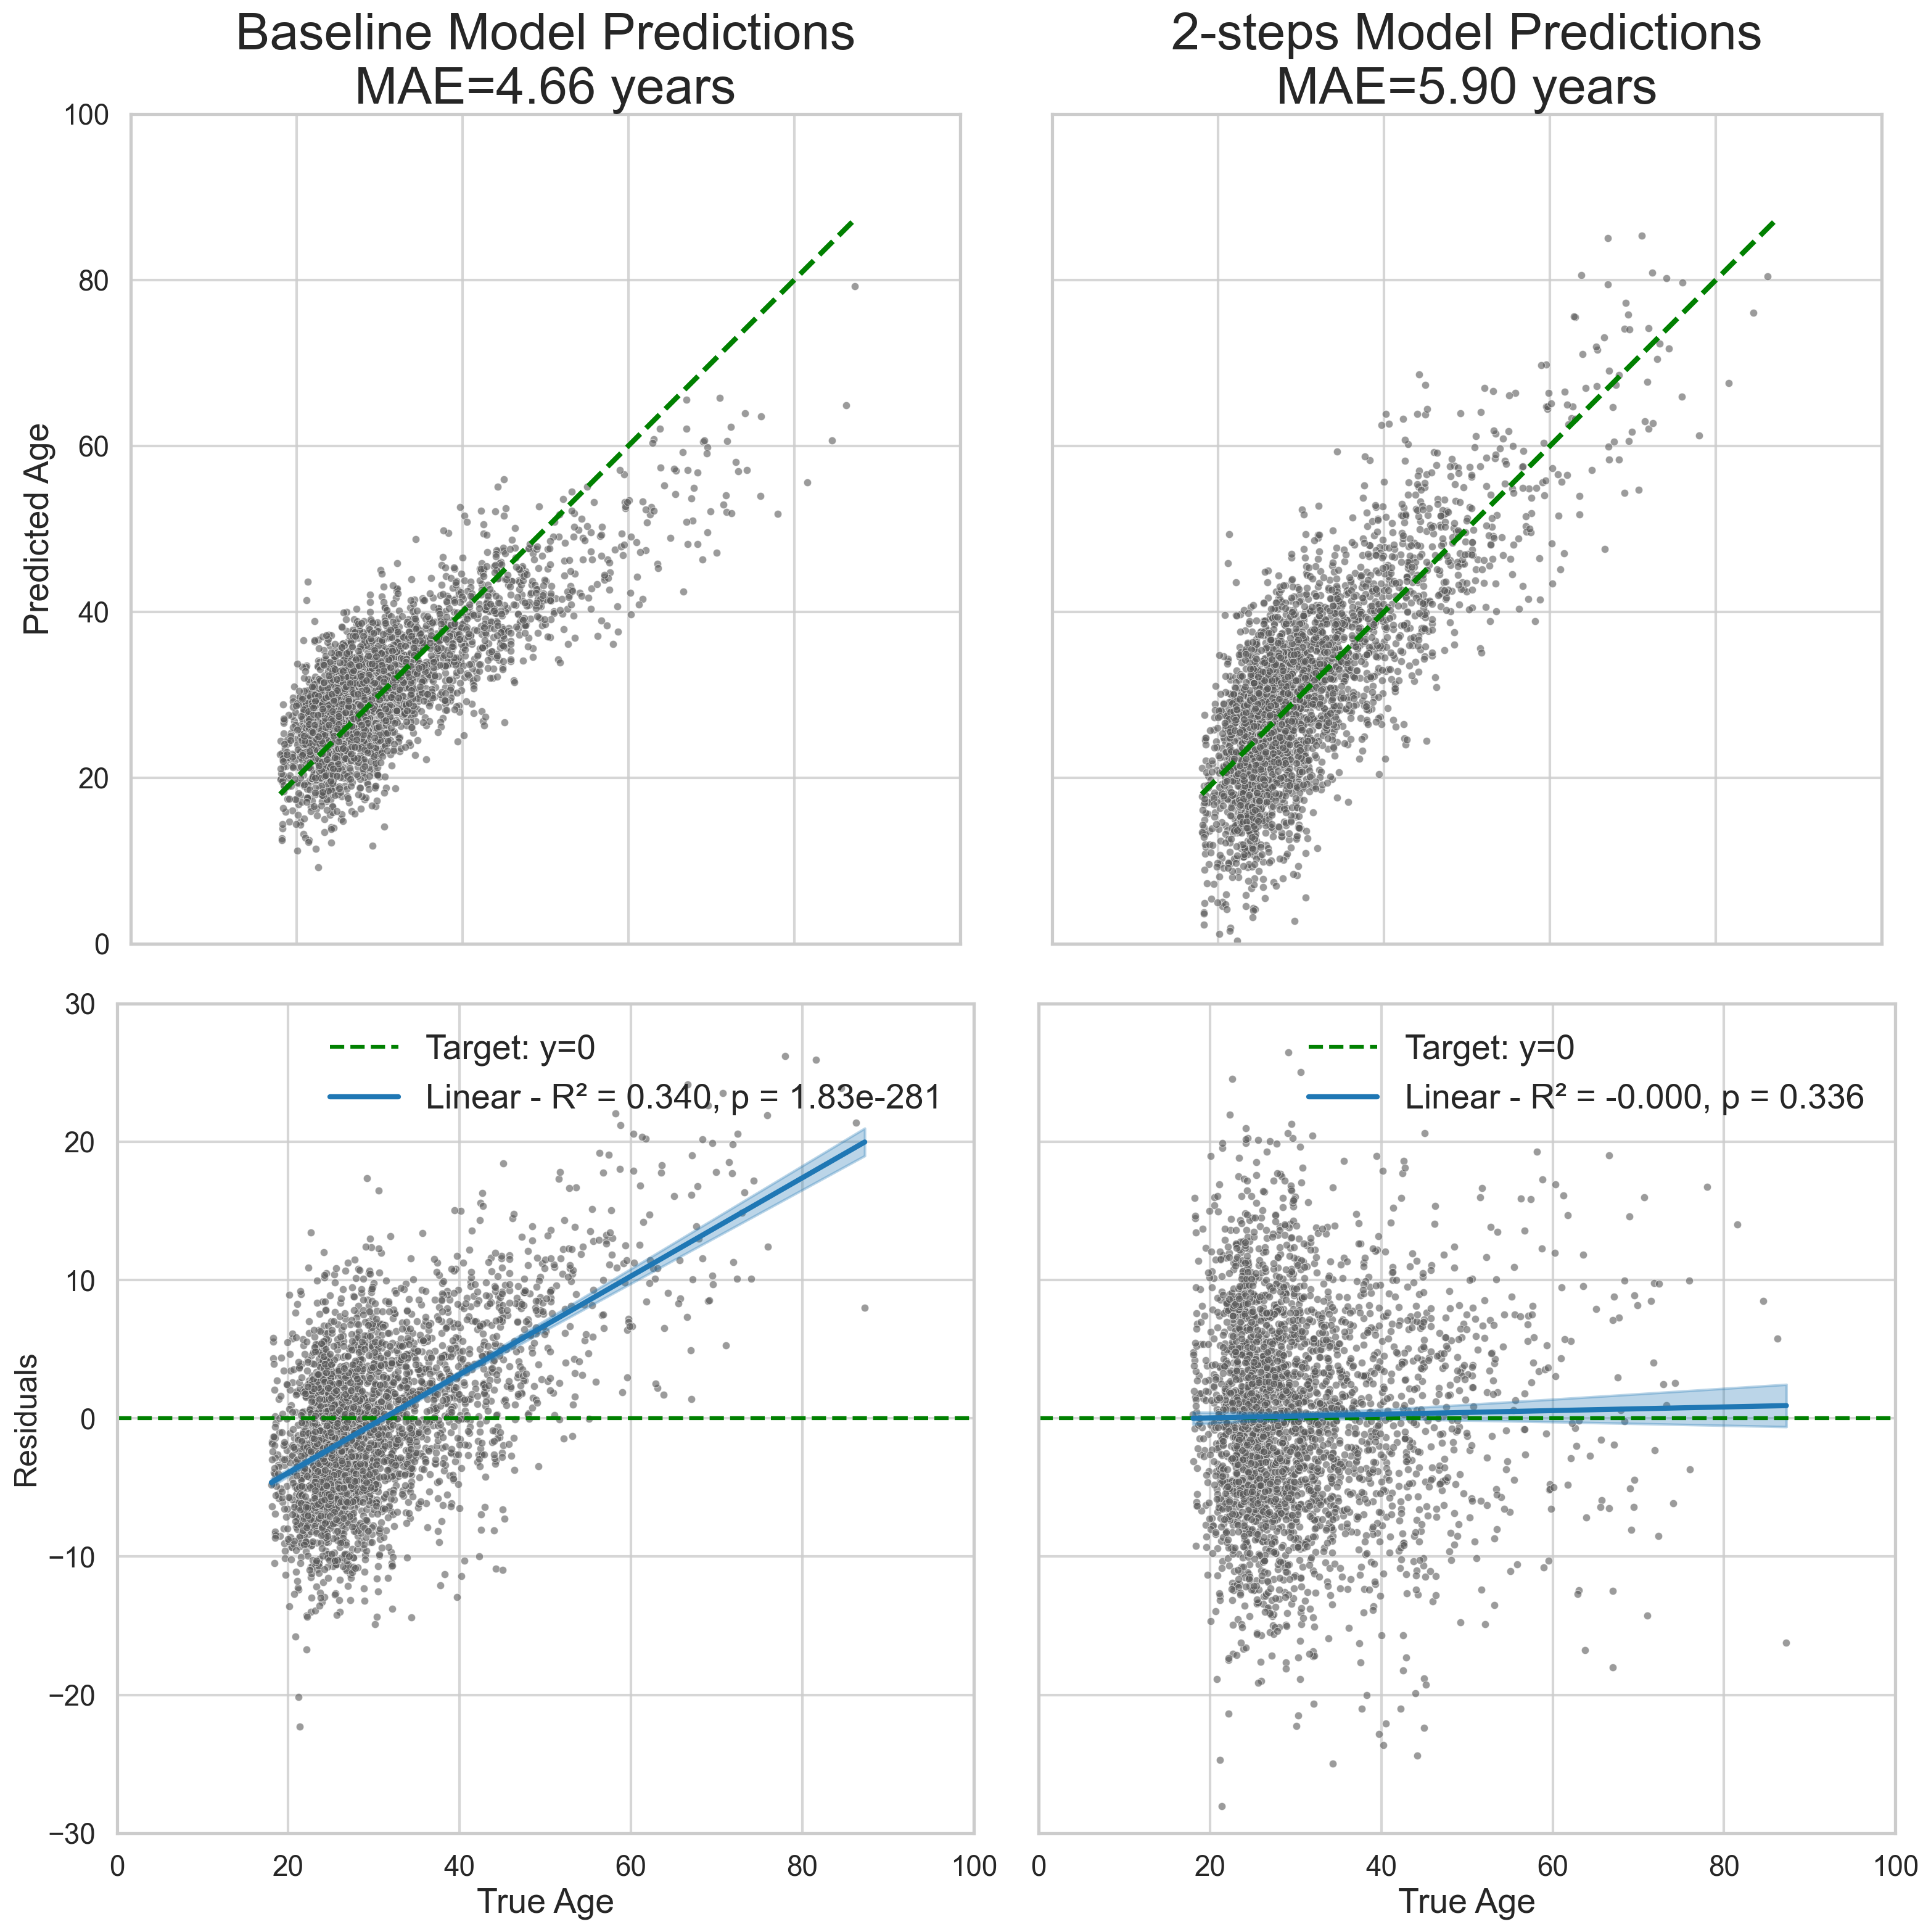

In [18]:
# plot actual vs predicted for all of the models
# plot residuals vs age for all of the models
from statsmodels.formula.api import ols
import statsmodels.api as sm

keys_vis = {
    "baseline": "Baseline Model",
    "weighted": "Census-Weighted Model",
    "linear_ph": "2-steps Model",
    "quadratic_ph": "Quadratic Post-hoc",
    "combined": "Census-Weighted 2-steps Model",
}

title_fontsize = 30
rest_fontsize = 20

nmodels = len(weighting_predictions)
fig, axes = plt.subplots(2, nmodels, figsize=(8 * nmodels, 16), sharey=False, sharex=True)
for i, (key, df) in enumerate(weighting_predictions.items()):
    ax = axes[0, i]
    sns.scatterplot(data=df, x="True", y="Predicted", ax=ax, s=20, color=COL_REF, alpha=0.6)
    ax.set_title(
        f"{keys_vis[key]} Predictions\nMAE={weighting_df.loc[key, 'MAE']:.2f} years", fontsize=title_fontsize
    )
    ax.set_aspect("equal")
    ax.set_xlabel("")
    ax.plot(
        [df["True"].min(), df["True"].max()],
        [df["True"].min(), df["True"].max()],
        color="green",
        linestyle="--",
        lw=3,
    )
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    if i == 0:
        ax.set_ylabel("Predicted Age", fontsize=rest_fontsize)
    else:
        ax.set_ylabel("")
        # remove y-axis tick labels
        ax.set_yticklabels([])


for i, (key, df) in enumerate(weighting_predictions.items()):
    ax = axes[1, i]
    if "ph" in key:
        y_col = "corrected_residuals"
    else:
        df["raw_residuals"] = df["True"] - df["Predicted"]
        y_col = "raw_residuals"
    df = df.rename(columns={"True": "age_at_scan"})
    sns.scatterplot(data=df, x="age_at_scan", y=y_col, ax=ax, s=20, color=COL_REF, alpha=0.6)

    # estimate linear and quadratic fit between residuals and age
    lin_m = ols(f"{y_col} ~ age_at_scan", data=df).fit()
    poly_m = ols(f"{y_col} ~ age_at_scan + I(age_at_scan ** 2)", data=df).fit()
    # draw the "target": y = 0 line
    ax.axhline(0, color="green", linestyle="--", label="Target: y=0")
    # plot the linear fit
    x_vals = np.linspace(df["age_at_scan"].min(), df["age_at_scan"].max(), 300)
    x_frame = pd.DataFrame({"age_at_scan": x_vals})
    # find the p-value for the linear fit
    p_value = lin_m.f_pvalue
    # For visualisation, find the p < {something} value
    p_vis = f"{p_value:.2e}" if p_value < 0.001 else f"{p_value:.3f}"
    lin_label = f"Linear - R² = {lin_m.rsquared_adj:.3f}, p = {p_vis}"
    # get predictions with CI
    lin_predictions = lin_m.get_prediction(x_frame)
    lin_predictions = lin_predictions.summary_frame(alpha=0.05)
    # plot the linear fit with confidence intervals
    ax.plot(x_vals, lin_m.predict(x_frame), color=COL_RAW, label=lin_label, lw=3)
    ax.fill_between(
        x_vals,
        lin_predictions["mean_ci_lower"],
        lin_predictions["mean_ci_upper"],
        color=COL_RAW,
        alpha=0.3,
    )
    # plot the quadratic fit
    # poly_label = f"Quadratic - R² = {poly_m.rsquared:.2f}, AIC = {poly_m.aic:.1f}"
    # get predictions with CI
    # poly_predictions = poly_m.get_prediction(x_frame)
    # poly_predictions = poly_predictions.summary_frame(alpha=0.05)
    # plot the quadratic fit with confidence intervals
    # ax.plot(
    #     x_vals, poly_m.predict(x_frame), color=COL_WEIGHTED, label=poly_label, lw=3
    # )
    # ax.fill_between(
    #     x_vals,
    #     poly_predictions["mean_ci_lower"],
    #     poly_predictions["mean_ci_upper"],
    #     color=COL_WEIGHTED, alpha=0.3
    # )
    # ax.set_title(f"{keys_vis[key]} Residuals\nMAE={weighting_df.loc[key, 'MAE_weighted']:.2f} years")
    ax.legend(frameon=False, loc="upper right", fontsize=rest_fontsize)

    ax.set_xlabel("True Age", fontsize=rest_fontsize)
    if i == 0:
        ax.set_ylabel("Residuals")
    else:
        ax.set_ylabel("")
        # remove y-axis tick labels
        ax.set_yticklabels([])
    ax.set_ylim(-30, 30)

    # ax.set_xlim(df["age_at_scan"].min(), df["age_at_scan"].max())
    # ax.legend(frameon=False)
plt.tight_layout()
# savefig_nice(
#     fig,
#     OUTPUT_DIR / f"fig3_weighted_predictions_{metric}.png",
#     tight=True,
#     dpi=300,
# )
# savefig_nice(
#     fig,
#     OUTPUT_DIR / "global_efficiency.png",
#     tight=True,
#     dpi=300,
# )

In [22]:
import numpy as np, pandas as pd
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

alphas = np.logspace(-3, 4, 30)  # ridge λ grid

perf_rows = []

use_weights = False
# do_post_hoc_correction = True
post_hoc_degree = 1

predictions = {}

for metric, X in X_dict.items():
    # Optionally concatenate covariates
    covariates = cov_names[metric]
    if cov_names:
        X_model = np.hstack([X, cov[covariates].to_numpy()])
    else:
        X_model = X
    # y_pred = stratified_regression_cv(X_model, y, w, n_splits=10, n_bins=10)

    # # Model & CV (same ridge code as before)
    model = Pipeline(
        [
            ("scaler", scaler),
            ("imputer", SimpleImputer(strategy="mean")),  # Handle missing values
            ("estimator", estimator),
        ]
    )

    y_pred, original_residuals, corrected_residuals = cross_val_predict_with_bias_correction(
        model=model,
        X=X_model,
        y_chronological=y,
        w=w,
        cv=outer_cv,
        use_weights=use_weights,
        post_hoc_degree=post_hoc_degree,
        # residual_orthog_degree=post_hoc_degree,
        groups = groups
    )

    # y_pred = cross_val_predict(
    #     model,
    #     X_model,
    #     y,
    #     # groups=age_strata(y),
    #     cv=outer_cv,
    #     params={"estimator__sample_weight": w if use_weights else None},
    #     n_jobs=-1,
    # )
    # if do_post_hoc_correction:
    #     resid = y - y_pred
    #     z = np.polyfit(y, resid, 2)
    #     p = np.poly1d(z)
    #     y_pred = y_pred + p(y)
    # # Save predictions
    predictions_df = cov.copy()
    predictions_df["True"] = y
    predictions_df["Predicted"] = y_pred
    predictions_df["raw_residuals"] = original_residuals
    predictions_df["corrected_residuals"] = corrected_residuals
    predictions[metric] = predictions_df
    perf_rows.append(
        dict(
            metric=metric,
            # R2=r2_score(y, y_pred, sample_weight=w if use_weights else None),
            # MAE=mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None),
            # RMSE=root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None),
            R2=r2_score(y, y_pred),
            R2_weighted=r2_score(y, y_pred, sample_weight=w),
            MAE=mean_absolute_error(y, y_pred),
            MAE_weighted=mean_absolute_error(y, y_pred, sample_weight=w),
            RMSE=root_mean_squared_error(y, y_pred),
            RMSE_weighted=root_mean_squared_error(y, y_pred, sample_weight=w),
        )
    )
    # break

In [23]:
# compare between linear and quadratic association between raw residuals and age
m = "gm_vol"
predictions_df = predictions[m].copy().rename(columns={"True": "age_at_scan"})
# linear
lin_mod = ols("raw_residuals ~ age_at_scan", data=predictions_df).fit()
# quadratic
quad_mod = ols("raw_residuals ~ age_at_scan + I(age_at_scan ** 2)", data=predictions_df).fit()
print(f"Linear model R²: {lin_mod.rsquared:.3f}")
print(f"Linear model AIC: {lin_mod.aic:.3f}")
print(f"Quadratic model R²: {quad_mod.rsquared:.3f}")
print(f"Quadratic model AIC: {quad_mod.aic:.3f}")

# sns.scatterplot(data=predictions[m], x="True", y="raw_residuals")
# sns.scatterplot(data=predictions[m], x="True", y="corrected_residuals")

Linear model R²: 0.340
Linear model AIC: 18513.362
Quadratic model R²: 0.342
Quadratic model AIC: 18507.920


6.018427187859277
0.3468052835385006


(0.0, 100.0)

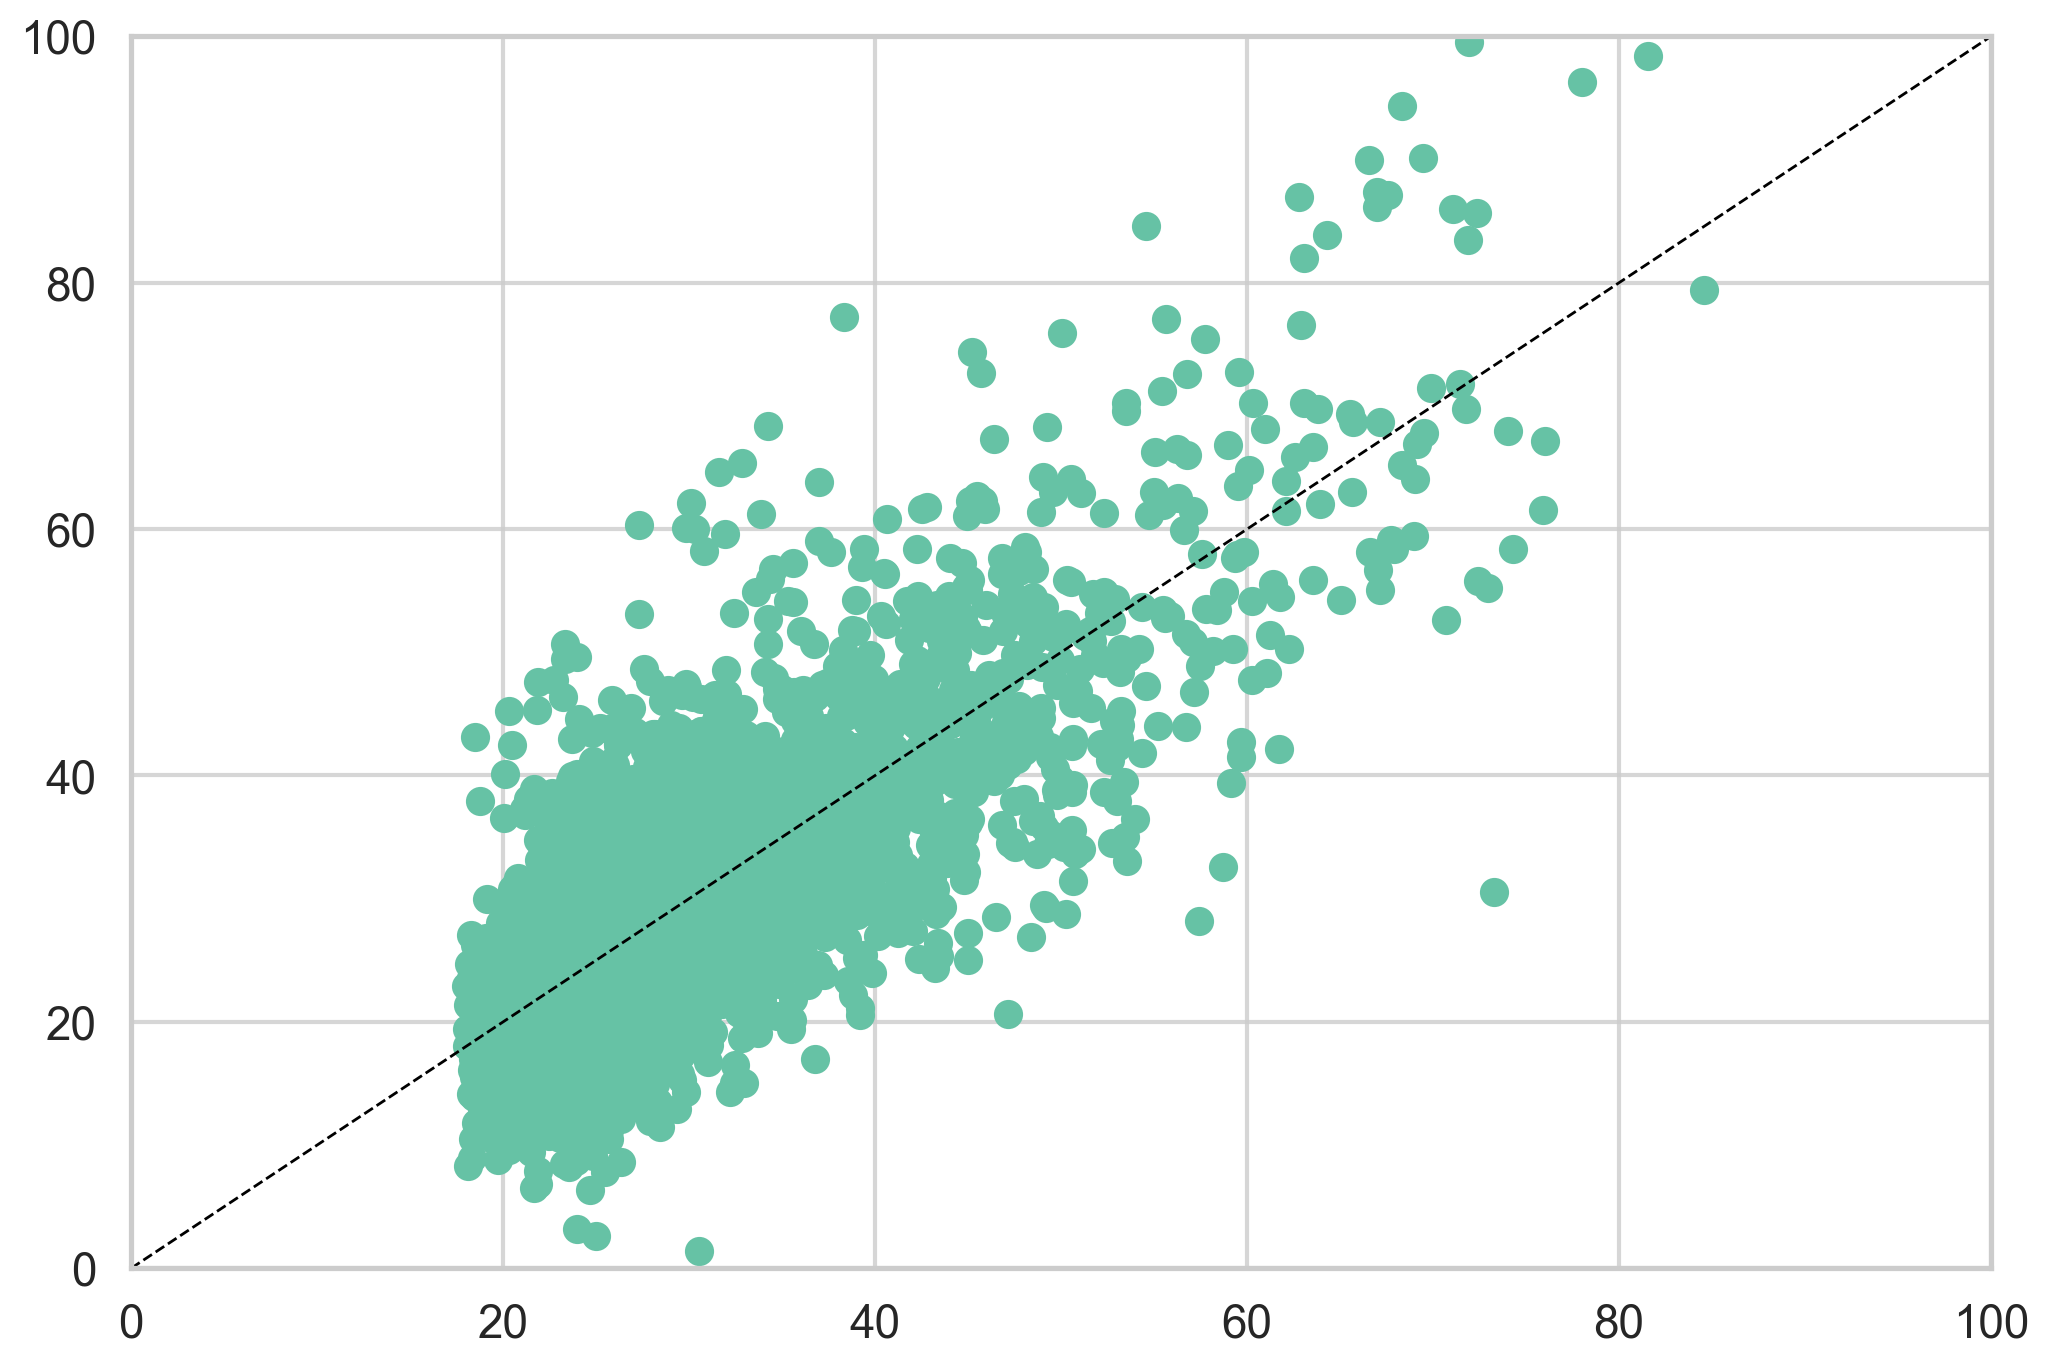

In [24]:
print(mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None))
print(r2_score(y, y_pred, sample_weight=w if use_weights else None))
plt.scatter(y, y_pred)
plt.plot([0, 100], [0, 100], color="black", linestyle="--", linewidth=1)
plt.xlim(0, 100)
plt.ylim(0, 100)

In [25]:
from scipy.stats import spearmanr

spearmanr(predictions["gm_vol"]["True"], predictions["gm_vol"]["corrected_residuals"])

SignificanceResult(statistic=np.float64(-0.000884822191501818), pvalue=np.float64(0.9607874846665014))

In [26]:
pd.DataFrame(perf_rows).set_index("metric")

R2  R2_weighted       MAE  MAE_weighted      RMSE  RMSE_weighted
metric                                                                        
gm_vol  0.420837     0.420837  5.899860      5.899860  7.436574       7.436574
adc     0.322489     0.322489  6.119047      6.119047  8.043238       8.043238
fa      0.437802     0.437802  5.674448      5.674448  7.326852       7.326852
ad      0.351038     0.351038  5.946687      5.946687  7.871949       7.871949
rd      0.346805     0.346805  6.018427      6.018427  7.897579       7.897579

In [27]:
pd.DataFrame(perf_rows).set_index("metric").sort_values("MAE", ascending=True)

R2  R2_weighted       MAE  MAE_weighted      RMSE  RMSE_weighted
metric                                                                        
fa      0.437802     0.437802  5.674448      5.674448  7.326852       7.326852
gm_vol  0.420837     0.420837  5.899860      5.899860  7.436574       7.436574
ad      0.351038     0.351038  5.946687      5.946687  7.871949       7.871949
rd      0.346805     0.346805  6.018427      6.018427  7.897579       7.897579
adc     0.322489     0.322489  6.119047      6.119047  8.043238       8.043238

In [28]:
# ### ----------- Concatenate all metrics into one model ----------- ###
# from sklearn.pipeline import make_pipeline

# X_concat = np.hstack([X_dict[m] for m in metrics])  # already row-aligned
# # add covariates
# covariates = pd.concat([cov[cov_names[m]] for m in metrics], axis=1)
# # drop duplicate columns
# covariates = covariates.loc[:, ~covariates.columns.duplicated()].to_numpy()
# X_concat = np.hstack([X_concat, covariates])

# pipe = Pipeline(
#     [
#         ("scaler", scaler),
#         ("estimator", estimator),
#     ]
# )
# y_pred, original_residuals, corrected_residuals = cross_val_predict_with_bias_correction(
#     model=pipe,
#     X=X_concat,
#     y_chronological=y,
#     w=w,
#     cv=outer_cv,
#     use_weights=use_weights,
#     post_hoc_degree=post_hoc_degree,
#     # residual_orthog_degree=post_hoc_degree,
# )

# # if do_post_hoc_correction:
# #     resid = y - y_pred
# #     z = np.polyfit(y, resid, 2)
# #     p = np.poly1d(z)
# #     y_pred = y_pred + p(y)
# # # Save predictions
# predictions_df = cov.copy()
# predictions_df["True"] = y
# predictions_df["Predicted"] = y_pred
# predictions_df["raw_residuals"] = original_residuals
# predictions_df["corrected_residuals"] = corrected_residuals
# predictions["concatenated"] = predictions_df
# perf_rows.append(
#     dict(
#         metric="concatenated",
#         R2=r2_score(y, y_pred),
#         R2_weighted=r2_score(y, y_pred, sample_weight=w),
#         MAE=mean_absolute_error(y, y_pred),
#         MAE_weighted=mean_absolute_error(y, y_pred, sample_weight=w),
#         RMSE=root_mean_squared_error(y, y_pred),
#         RMSE_weighted=root_mean_squared_error(y, y_pred, sample_weight=w),
#     )
# )

In [30]:
# polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

# ---------------------------------------------------------------------
# 2. Parcel-wise base-learner loop
# ---------------------------------------------------------------------
stacked_models = parcels.copy()

stacked_estimators = {}
predictions["base_stacked"] = {}

alphas = np.logspace(-3, 4, 30)  # ridge grid
for i, row in parcels.iterrows():  # i == parcel index (0..453)
    # ------------- build design matrix for parcel i -----------------
    # X_roi : (n_subjects , 5 metrics)
    # X_cov = cov[cov_names["gm_vol"]].to_numpy()
    X_roi = np.hstack([X_dict[m][:, [i]] for m in metrics])
    # X_roi = np.hstack([X_roi, X_cov])  # add covariates

    pipe = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            # ("poly", PolynomialFeatures(degree=2)),
            ("imputer", SimpleImputer(strategy="mean")),  # Handle missing values
            ("estimator", RidgeCV(alphas=alphas)),
            # ("estimator", RandomForestRegressor())
        ]
    )

    # ---------------- fit model & predict --------------------------
    y_pred, original_residuals, corrected_residuals = cross_val_predict_with_bias_correction(
        model=pipe,
        X=X_roi,
        y_chronological=y,
        w=w,
        cv=outer_cv,
        use_weights=use_weights,
        post_hoc_degree=0,
        # residual_orthog_degree=post_hoc_degree,
        groups=groups,
    )

    # ---------------- store predictions & metrics -------------------
    pred_df = cov.copy()
    pred_df["True"] = y
    pred_df["Predicted"] = y_pred
    pred_df["raw_residuals"] = original_residuals
    pred_df["corrected_residuals"] = corrected_residuals
    predictions["base_stacked"][i] = pred_df
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    r2_weighted = r2_score(y, y_pred, sample_weight=w)
    mae_weighted = mean_absolute_error(y, y_pred, sample_weight=w)
    rmse_weighted = root_mean_squared_error(y, y_pred, sample_weight=w)

    stacked_models.loc[
        i, ["R2", "MAE", "RMSE", "R2_weighted", "MAE_weighted", "RMSE_weighted"]
    ] = [r2, mae, rmse, r2_weighted, mae_weighted, rmse_weighted]
    stacked_estimators[i] = pipe

<Axes: >

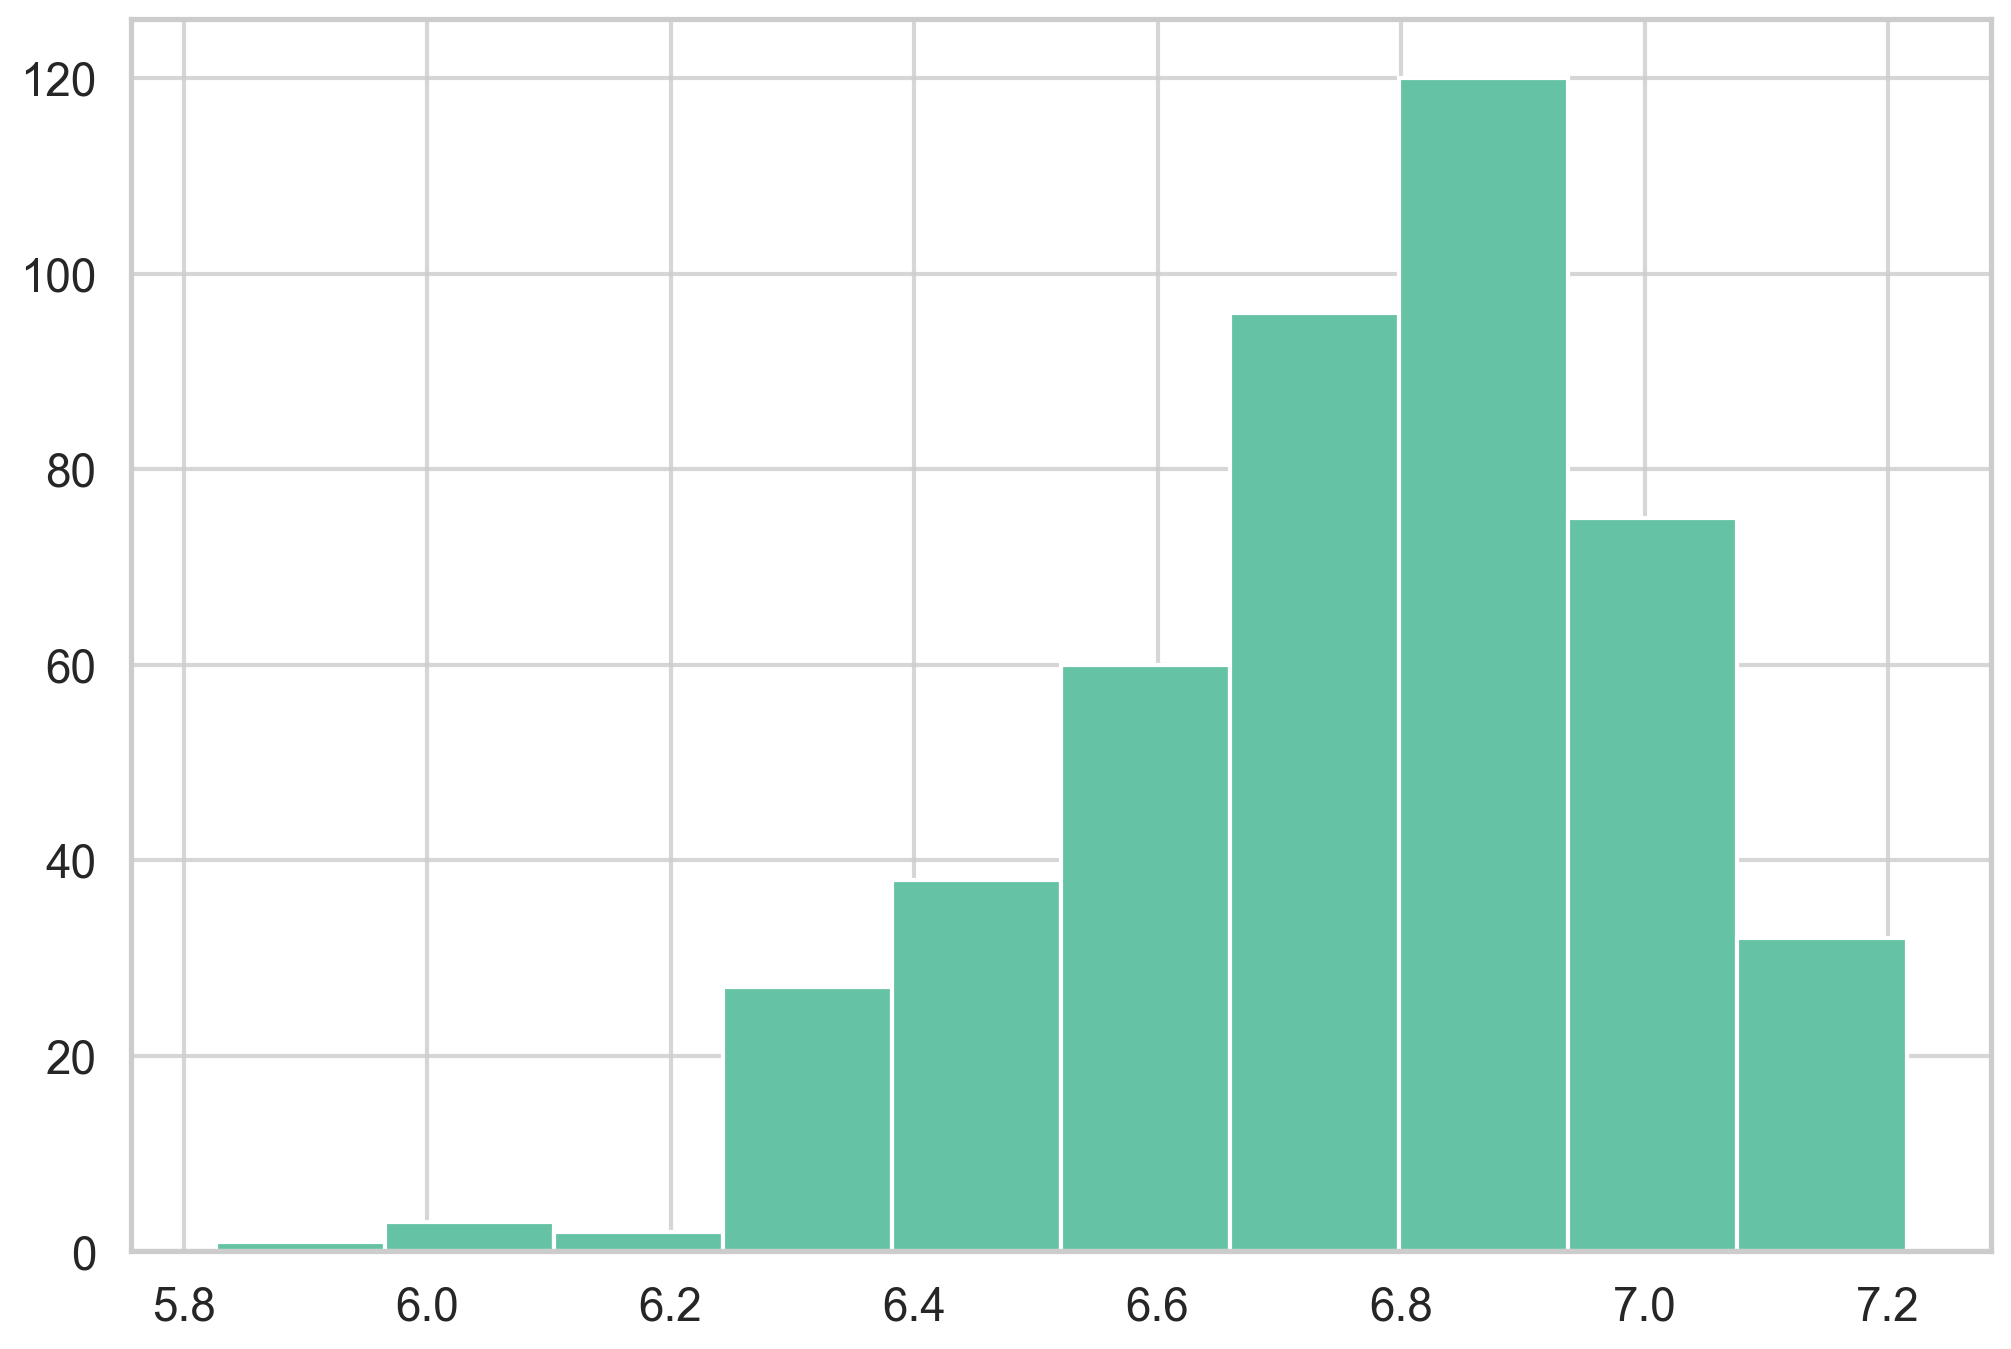

In [31]:
stacked_models["MAE"].hist()
# stacked_models.sort_values("MAE_weighted", ascending=False)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)

# ------------------------------------------------------------------
# 1.  Build the meta-feature matrix  (n_subj × n_parcels [+ covariates])
# ------------------------------------------------------------------
# stack parcel OOF columns → shape (454, n_subj) → transpose
X_cov = cov[cov_names["gm_vol"]].to_numpy()
X_stacked = np.vstack(
    [predictions["base_stacked"][i]["Predicted"].to_numpy() for i in predictions["base_stacked"]]
).T  # (n_subj, n_parcels)

# Optionally add covariates (e.g., sex, TIV)
X_stacked = np.hstack([X_stacked, X_cov])  # (n_subj, n_parcels + n_covariates)

# ------------------------------------------------------------------
# 2.  Meta-learner pipeline (standardised ridge with CV on λ)
# ------------------------------------------------------------------
pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(strategy="mean")),  # Handle missing values
        ("estimator", RidgeCV(alphas=alphas)),
    ]
)

# ------------------------------------------------------------------
# 3.  Out-of-fold meta predictions with fold-wise bias correction
# ------------------------------------------------------------------
y_pred, original_residuals, corrected_residuals = cross_val_predict_with_bias_correction(
    model=pipe,
    X=X_stacked,
    y_chronological=y,
    w=w,
    cv=outer_cv,
    use_weights=use_weights,
    post_hoc_degree=post_hoc_degree,
    # residual_orthog_degree=post_hoc_degree,
    groups=groups,
)

# ------------------------------------------------------------------
# 4.  Store predictions and performance
# ------------------------------------------------------------------
pred_df = cov.copy()
pred_df["True"] = y
pred_df["Predicted"] = y_pred
pred_df["raw_residuals"] = original_residuals
pred_df["corrected_residuals"] = corrected_residuals
predictions["stacked"] = pred_df


perf_rows.append(
    dict(
        metric="stacked",
        R2=r2_score(y, y_pred),
        R2_weighted=r2_score(y, y_pred, sample_weight=w),
        MAE=mean_absolute_error(y, y_pred),
        MAE_weighted=mean_absolute_error(y, y_pred, sample_weight=w),
        RMSE=root_mean_squared_error(y, y_pred),
        RMSE_weighted=root_mean_squared_error(y, y_pred, sample_weight=w),
    )
)

In [33]:
dict(
    metric="stacked",
    R2=r2_score(y, y_pred),
    R2_weighted=r2_score(y, y_pred, sample_weight=w),
    MAE=mean_absolute_error(y, y_pred),
    MAE_weighted=mean_absolute_error(y, y_pred, sample_weight=w),
    RMSE=root_mean_squared_error(y, y_pred),
    RMSE_weighted=root_mean_squared_error(y, y_pred, sample_weight=w),
)

{'metric': 'stacked',
 'R2': 0.5842560753522609,
 'R2_weighted': 0.5842560753522609,
 'MAE': 4.857907133319272,
 'MAE_weighted': 4.857907133319272,
 'RMSE': 6.3006539777587625,
 'RMSE_weighted': 6.3006539777587625}

In [34]:
perf_df = pd.DataFrame(perf_rows).set_index("metric").sort_values("MAE", ascending=True)

In [35]:
perf_df["is_best"] = perf_df["MAE"] == perf_df["MAE"].min()
# set is_best == False to gray and True to green (use RGB colors)
perf_df["color"] = perf_df["is_best"].map({True: "green", False: "gray"})

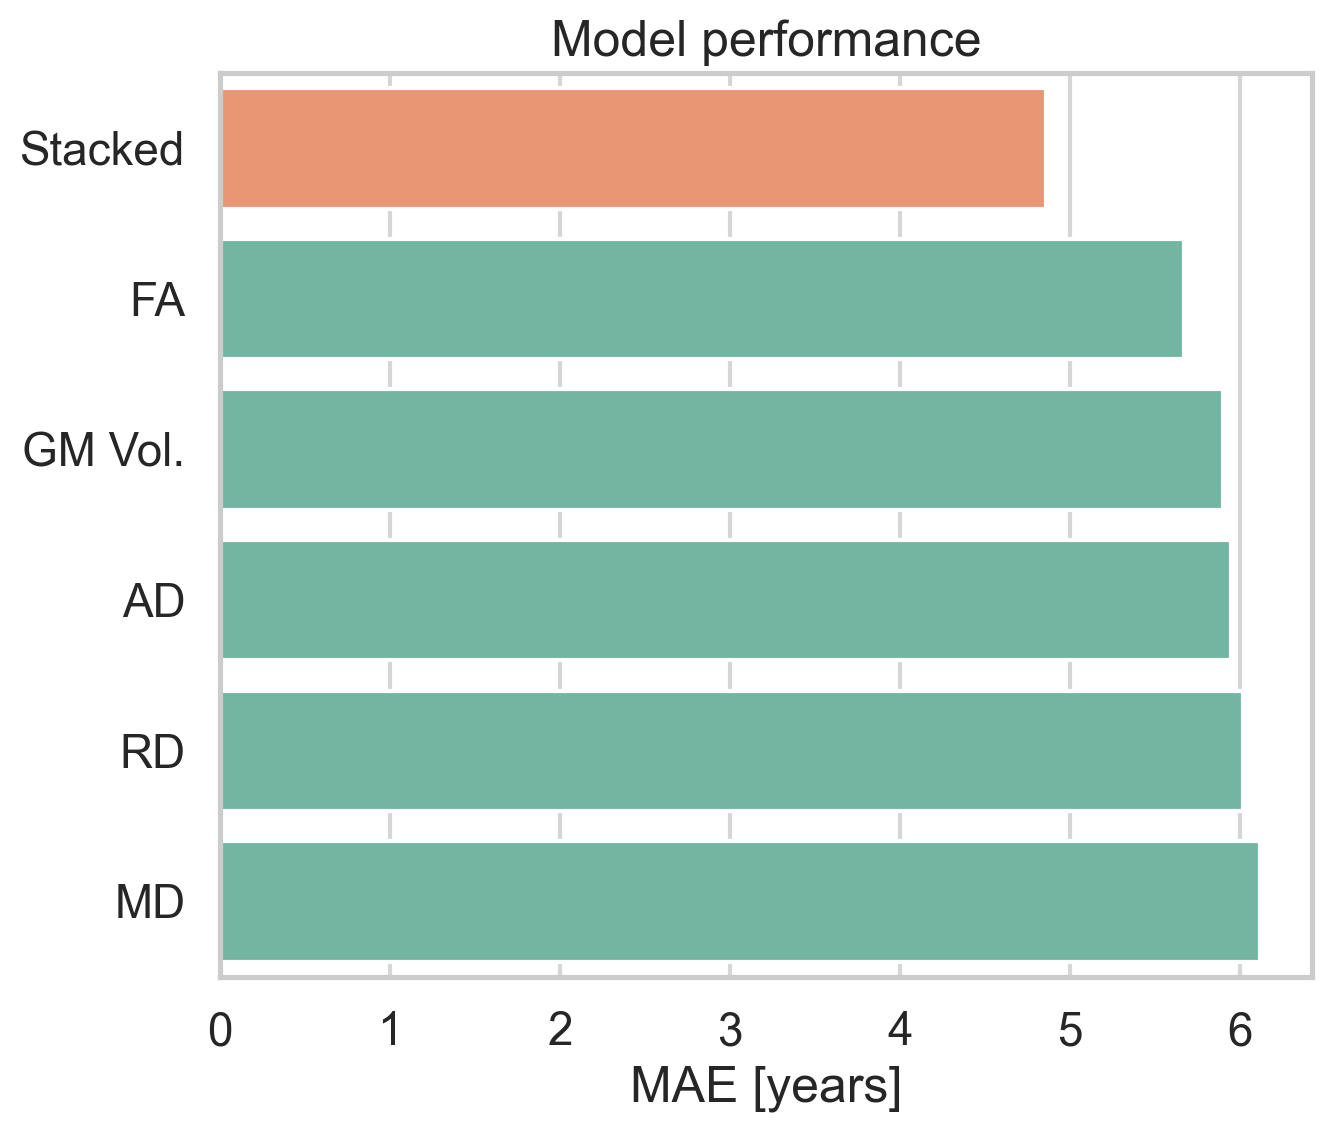

In [36]:
# -----------------------------------------------------------
# 2.  barplot with 95 % BCa bootstrap CIs on R²
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

ticks_mapping = {
    "gm_vol": "GM Vol.",
    "rd": "RD",
    "fa": "FA",
    "ad": "AD",
    "adc": "MD",
    "stacked": "Stacked",
}

fig, ax = plt.subplots(figsize=(7, 6))
sns.barplot(
    y="metric", x="MAE", data=perf_df.reset_index(), ax=ax, orient="h", hue="is_best",legend=False
)
# ax.errorbar(
#     x=np.arange(len(perf_df)),
#     y=perf_df["RMSE"],
#     # yerr=[perf_df["R2"] - ci_lo, ci_hi - perf_df["R2"]],
#     fmt="none",

#     capsize=4,
#     color="k",
#     lw=1,
# )
# change the y-ticks to the metric names
ax.set_yticks(np.arange(len(perf_df)))
ax.set_yticklabels([ticks_mapping.get(m, m) for m in perf_df.index])
# ax.set_ylabel("$R^{2}$  (10× CV, bias-corrected)")
ax.set_xlabel("MAE [years]")
ax.set_ylabel("")
ax.set_title("Model performance")
# ax.set_xticks(np.arange(0, 1.1, 0.1))
# ax.set_ylim(0.8, perf_df["R2"].max() * 1.15)
plt.tight_layout()
# ax.set_xlim(3,6)
# plt.savefig("metric_comparison_bias_corrected.png", dpi=400)
plt.show()

In [37]:
best_metric = perf_df.index[0]
# best_metric = "gm_vol"
y = predictions[best_metric]["True"].to_numpy()
y_pred = predictions[best_metric]["Predicted"].to_numpy()
# w = predictions[best_metric]["weight"].to_numpy()
df = (
    predictions[best_metric][["True", "Predicted"]]
    .copy()
    .rename(columns={"True": "age", "Predicted": "predicted"})
)

df["residuals"] = df["age"] - df["predicted"]
# # build a model to predict the residuals
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# import statsmodels.formula.api as smf

# # Fit a linear model to the residuals
# df["residuals"] = residuals
# model = ols("residuals ~ age", data=df).fit()
# # use the model to "fix" the predictions
# df["fixed_predicted"] = df["predicted"] + model.resid

/tmp/ipykernel_1164913/1895331150.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_1164913/1895331150.py:56: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


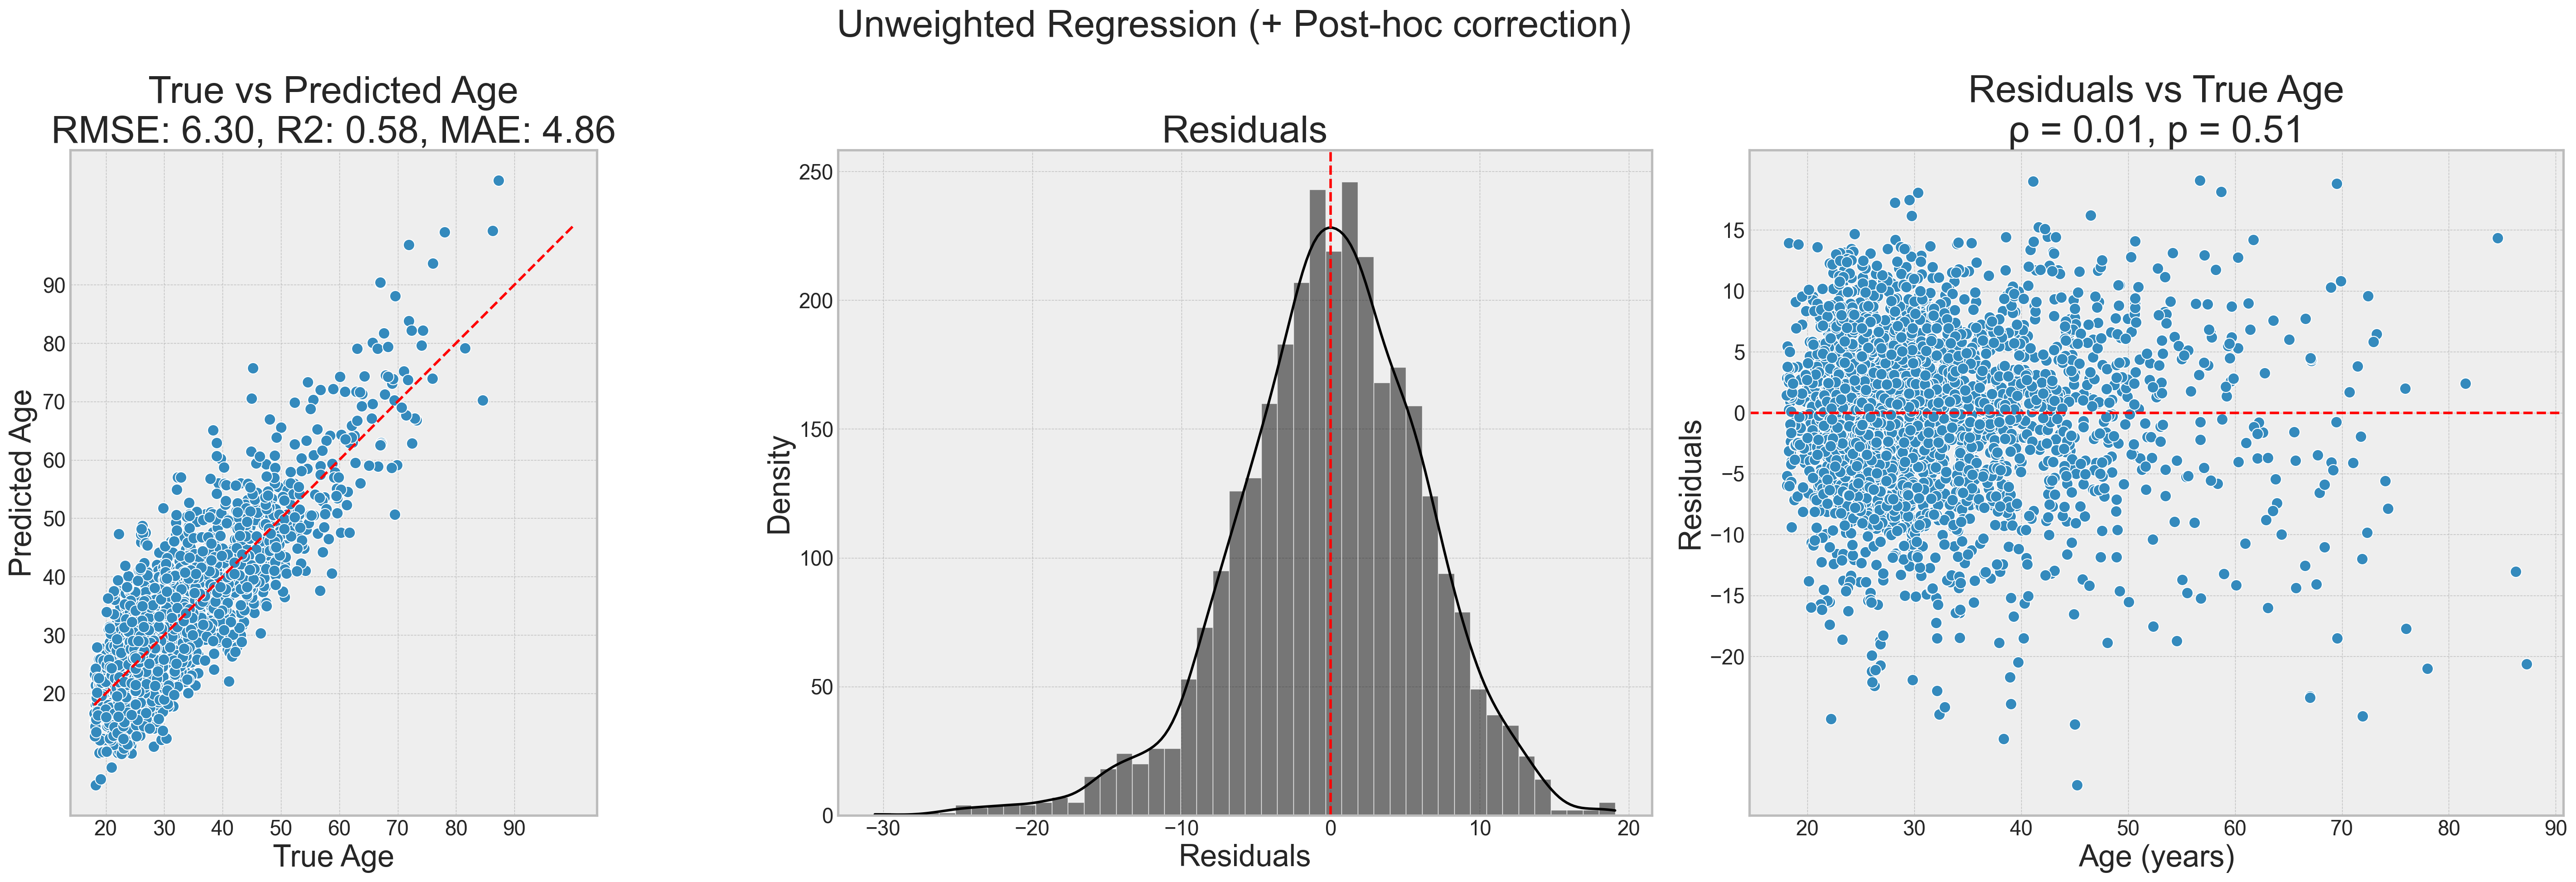

In [38]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

plt.style.use("bmh")

do_post_hoc_correction = True
use_weights = False

r2 = r2_score(y, y_pred, sample_weight=w if use_weights else None)
rmse = root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None)
mae = mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None)

# r2 = r2_score(y, y_pred)
# rmse = root_mean_squared_error(y, y_pred)
# mae = mean_absolute_error(y, y_pred)


title = f"True vs Predicted Age\nRMSE: {rmse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}"

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
# plot true vs predicted
ax = axes[0]
sns.scatterplot(
    data=df,
    x="age",
    y="predicted",
    ax=ax,
    # cmap="jet",
    # color by weight,
    # hue=w.flatten(),
    palette="viridis",
    # s=w * 10,
)
ax.plot([18, 100], [18, 100], "--", c="red")
ax.set_xlabel("True Age", fontsize=24)
ax.set_ylabel("Predicted Age", fontsize=24)
ax.set_title(title, fontsize=30)
ax.set_xticks(range(20, 100, 10))
ax.set_yticks(range(20, 100, 10))
# make axis square
ax.set_aspect("equal", "box")

# plot residuals
ax = axes[1]
sns.histplot(data=df, x="residuals", ax=ax, kde=True, color="black")
ax.set_xlabel("Residuals", fontsize=24)
ax.set_ylabel("Density", fontsize=24)
ax.set_title("Residuals", fontsize=30)
ax.axvline(0, color="red", linestyle="--")

# plot residuals vs true age

r, p = spearmanr(df["age"], df["residuals"])

ax = axes[2]
sns.scatterplot(
    data=df,
    x="age",
    y="residuals",
    ax=ax,
    # cmap="jet",
    # color by weight,
    # hue=w.flatten(),
    palette="viridis",
    # s=w * 10,
)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("Age (years)", fontsize=24)
ax.set_ylabel("Residuals", fontsize=24)
ax.set_title("Residuals vs True Age\nρ = {:.2f}, p = {:.2g}".format(r, p), fontsize=30)
ax.set_xticks(range(20, 100, 10))
ax.set_yticks(range(-20, 20, 5))
# make axis square

suptitle = "Weighted Regression" if use_weights else "Unweighted Regression"
if do_post_hoc_correction:
    suptitle += " (+ Post-hoc correction)"
fig.suptitle(suptitle, fontsize=30)

plt.tight_layout()

/tmp/ipykernel_1164913/186722643.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_1164913/186722643.py:57: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


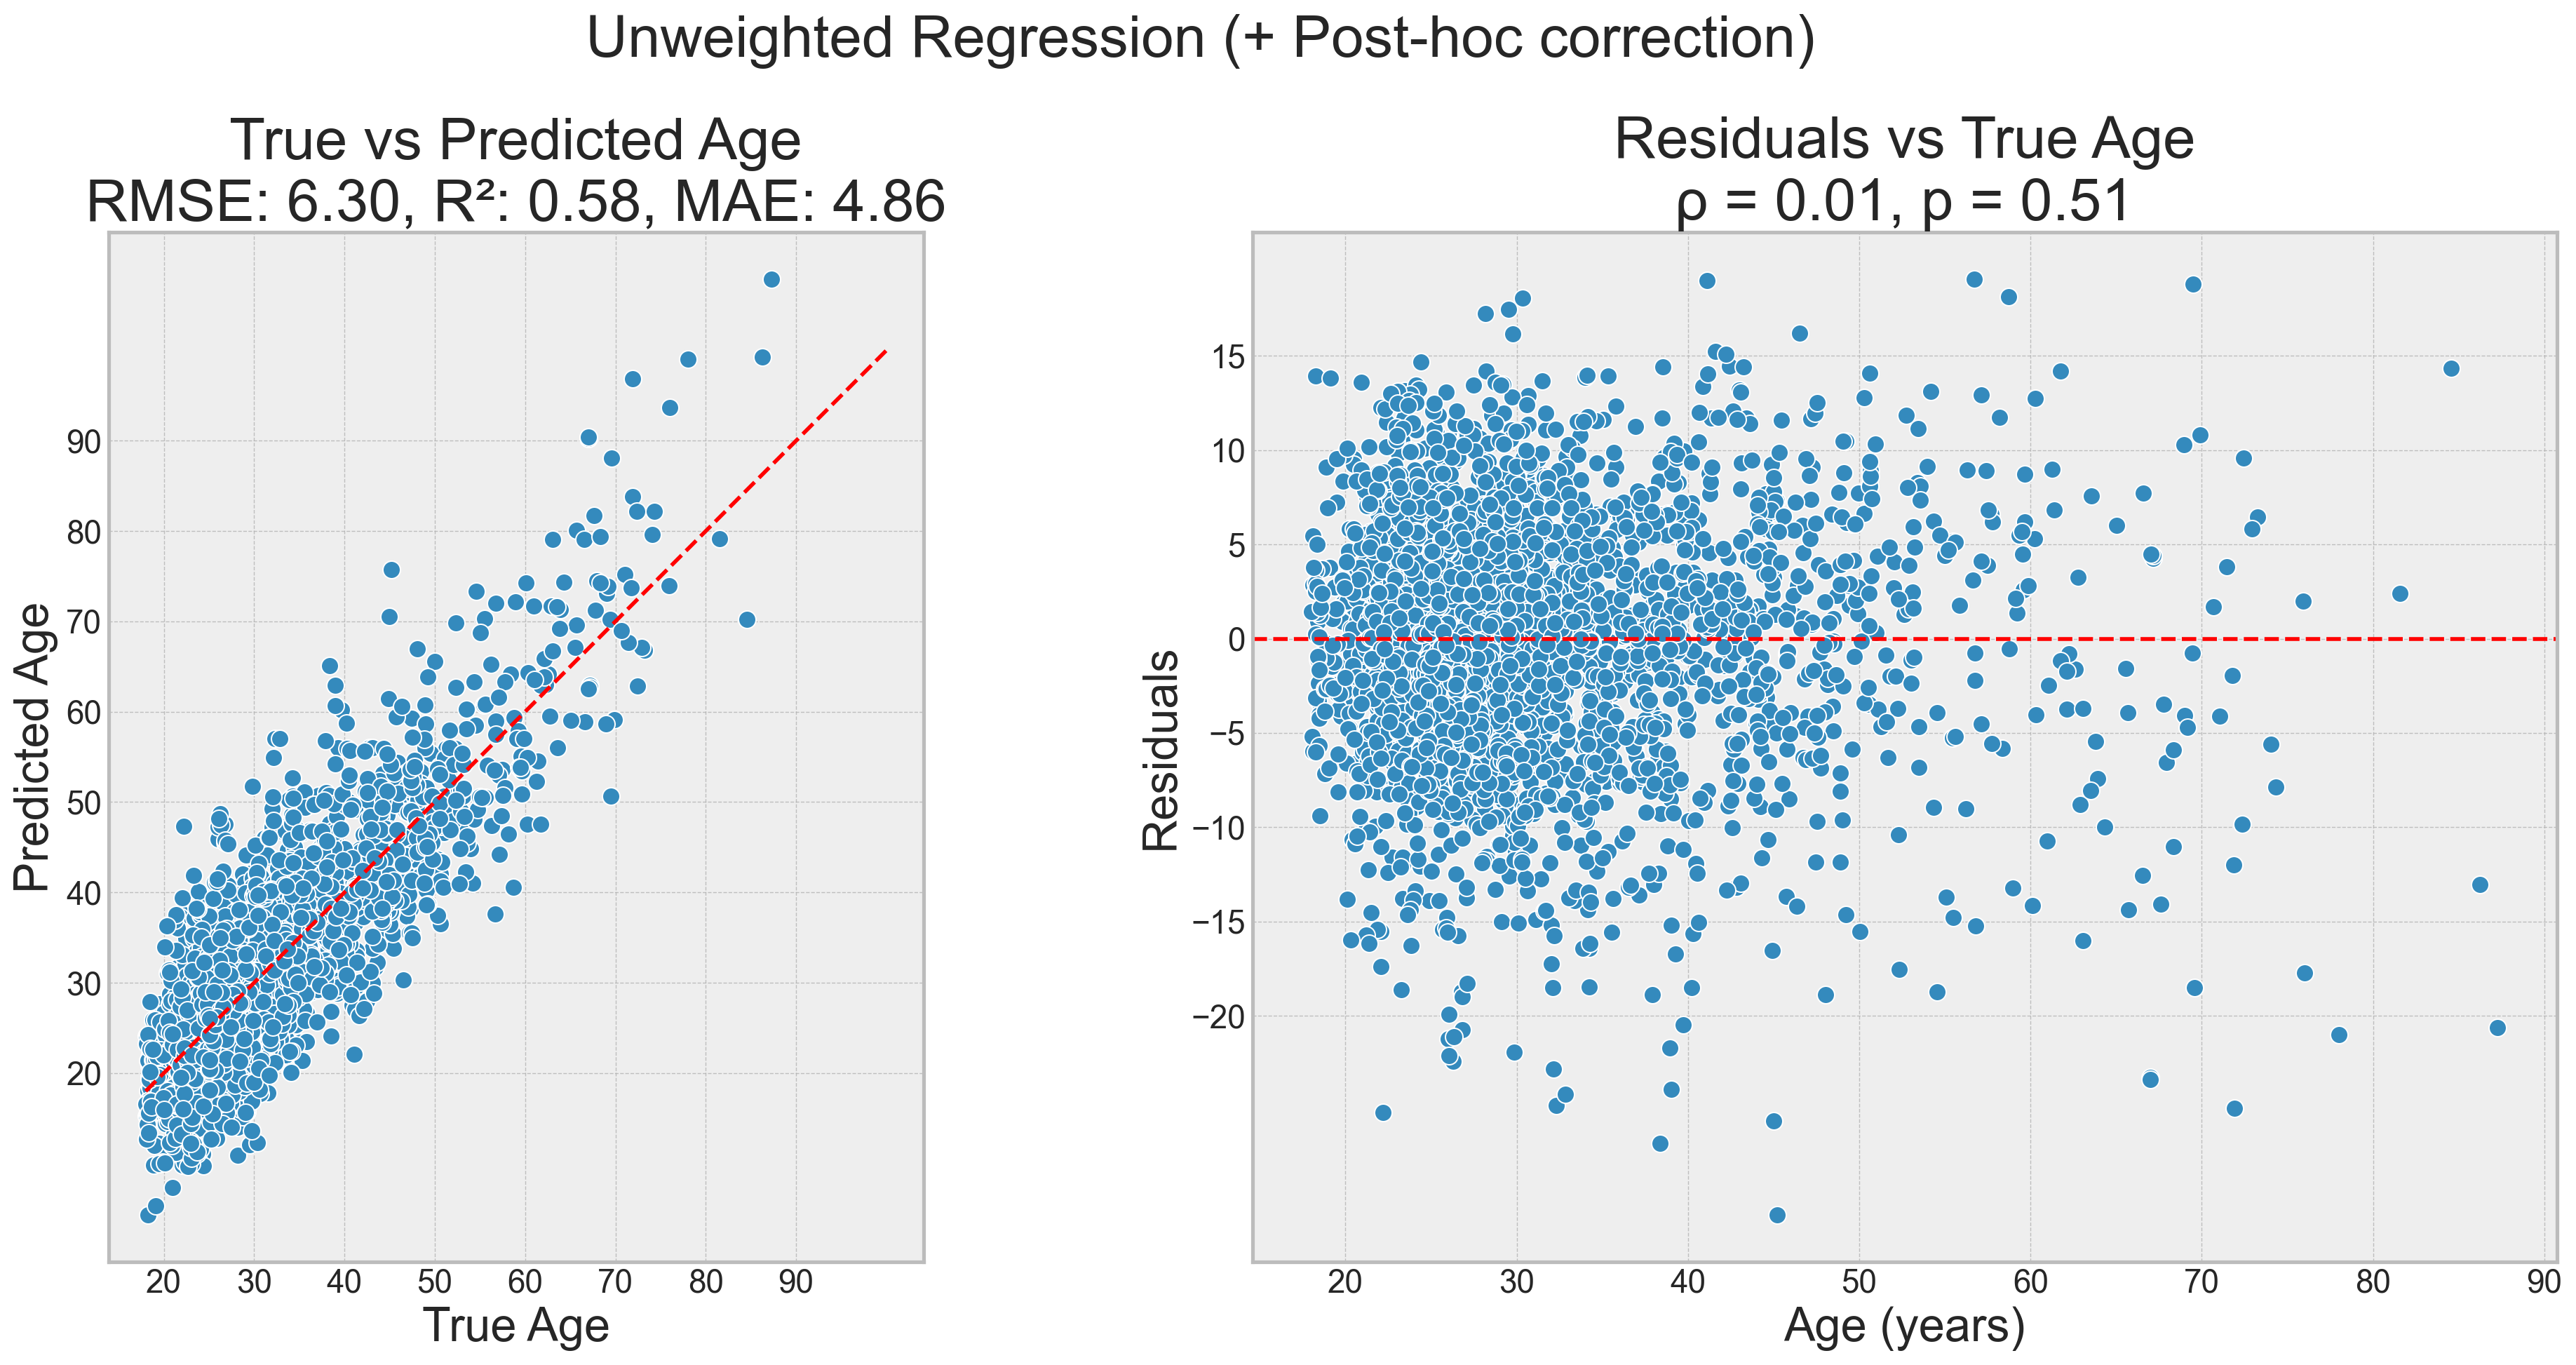

In [39]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

plt.style.use("bmh")

do_post_hoc_correction = True
use_weights = False

r2 = r2_score(y, y_pred, sample_weight=w if use_weights else None)
rmse = root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None)
mae = mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None)

# r2 = r2_score(y, y_pred)
# rmse = root_mean_squared_error(y, y_pred)
# mae = mean_absolute_error(y, y_pred)


# title = f"True vs Predicted Age\nRMSE: {rmse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}"
title = f"True vs Predicted Age\nRMSE: {rmse:.2f}, R²: {r2:.2f}, MAE: {mae:.2f}"

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# plot true vs predicted
ax = axes[0]
sns.scatterplot(
    data=df,
    x="age",
    y="predicted",
    ax=ax,
    # cmap="jet",
    # color by weight,
    # hue=w.flatten(),
    palette="viridis",
    # s=w * 10,
)
ax.plot([18, 100], [18, 100], "--", c="red")
ax.set_xlabel("True Age", fontsize=24)
ax.set_ylabel("Predicted Age", fontsize=24)
ax.set_title(title, fontsize=30)
ax.set_xticks(range(20, 100, 10))
ax.set_yticks(range(20, 100, 10))
# make axis square
ax.set_aspect("equal", "box")

# plot residuals
# ax = axes[1]
# sns.histplot(data=df, x="residuals", ax=ax, kde=True, color="black")
# ax.set_xlabel("Residuals", fontsize=24)
# ax.set_ylabel("Density", fontsize=24)
# ax.set_title("Residuals", fontsize=30)
# ax.axvline(0, color="red", linestyle="--")

# plot residuals vs true age

r, p = spearmanr(df["age"], df["residuals"])

ax = axes[1]
sns.scatterplot(
    data=df,
    x="age",
    y="residuals",
    ax=ax,
    # cmap="jet",
    # color by weight,
    # hue=w.flatten(),
    palette="viridis",
    # s=w * 10,
)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("Age (years)", fontsize=24)
ax.set_ylabel("Residuals", fontsize=24)
ax.set_title("Residuals vs True Age\nρ = {:.2f}, p = {:.2g}".format(r, p), fontsize=30)
ax.set_xticks(range(20, 100, 10))
ax.set_yticks(range(-20, 20, 5))
# make axis square

suptitle = "Weighted Regression" if use_weights else "Unweighted Regression"
if do_post_hoc_correction:
    suptitle += " (+ Post-hoc correction)"
fig.suptitle(suptitle, fontsize=30)

plt.tight_layout()

In [40]:
df.sort_values("residuals", ascending=True).head(10)
# df.shape

age  predicted  residuals
session_id                               
202303081309  45.21  75.766539 -30.556539
202211241846  38.35  65.116797 -26.766797
202311081701  44.99  70.551920 -25.561920
202111141118  22.20  47.325030 -25.125030
202302021141  71.92  96.820050 -24.900050
202104181204  32.32  57.061654 -24.741654
202211221710  32.83  57.004791 -24.174791
202504081510  39.02  62.912052 -23.892052
202209081542  67.01  90.402563 -23.392563
202208311853  66.99  90.273893 -23.283893

In [86]:
demo_cols = ["sex", "study", "group", "condition","target","subject_code"]

# demo = cov.groupby("session_id").first()
# demo[demo_cols]
df[demo_cols] = cov.groupby("session_id").first()[demo_cols]
df["target"] = demo.groupby("session_id").first()["target"]
# df["target"] = df["target"].fillna(False)

In [87]:
# import smf
from scipy.stats import ttest_ind

# mask_1 = (df["target"] == True) & (df["group"] == "Climbing")
# # mask_1 = (df["target"] == True) & (df["group"] == "Bjj")
# mask_2 = (df["target"] == False)
# val_col = "age"
# ttest_ind(
#     df.loc[mask_1,val_col], df.loc[mask_2,val_col], equal_var=False, nan_policy="omit"
# )

In [122]:
from scipy.stats import ttest_rel
learners = df[df["condition"] == "Learning"]
repeated_subjects = learners["subject_code"].value_counts() > 1
repeated = learners["subject_code"].isin(repeated_subjects[repeated_subjects].index)

learners = learners[repeated].reset_index()
# df[df["group"].isin(["Climbing","Bjj"])].groupby("condition").count()
climbers = learners[learners["group"] == "Climbing"].sort_values(["subject_code","session_id"])
climbers_before = climbers.drop_duplicates(subset=["subject_code"], keep="first")
climbers_after = climbers.drop_duplicates(subset=["subject_code"], keep="last")
# tag "before" and "after" sessions
climbers.loc[climbers["session_id"].isin(climbers_before["session_id"]), "tag"] = "before"
climbers.loc[climbers["session_id"].isin(climbers_after["session_id"]), "tag"] = "after"
bjj = learners[learners["group"] == "Bjj"].sort_values(["subject_code","session_id"])
bjj_before = bjj.drop_duplicates(subset=["subject_code"], keep="first")
bjj_after = bjj.drop_duplicates(subset=["subject_code"], keep="last")
# tag "before" and "after" sessions
bjj.loc[bjj["session_id"].isin(bjj_before["session_id"]), "tag"] = "before"
bjj.loc[bjj["session_id"].isin(bjj_after["session_id"]), "tag"] = "after"


ttest_rel(
    climbers_before["residuals"],
    climbers_after["residuals"],
    nan_policy="omit",
    # alternative="greater",  # one-tailed test
)




TtestResult(statistic=np.float64(2.6273102015757708), pvalue=np.float64(0.009894726652551372), df=np.int64(105))

In [110]:
climbers.groupby("tag").mean(numeric_only=True)

session_id        age  predicted  residuals       sex  height  \
tag                                                                       
after   2.023288e+11  30.002453  29.928832   0.073621  0.481132     NaN   
before  2.023043e+11  29.835347  28.838722   0.996625  0.495050     NaN   

        weight  
tag             
after      NaN  
before     NaN

In [123]:
# do linear regression with statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_ols = df[df["target"].notna()].copy()  # filter out rows with NaN in target
# df_ols = df_ols[df_ols["condition"] != "Learning"]
# df_ols["target"] = df_ols["target"].astype(int)  # convert target to int (0 or 1)
# df_ols["y"] = df_ols["target"] & (df_ols["group"] == "Bjj")
df_ols["y"] = df_ols["target"]

mod = ols(
    "residuals ~ age + C(y) + C(sex)",
    data=df_ols,
).fit()  # fit a linear model with residuals as dependent variable

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.661
Date:                Mon, 30 Jun 2025   Prob (F-statistic):             0.0121
Time:                        14:10:30   Log-Likelihood:                -3967.2
No. Observations:                1220   AIC:                             7942.
Df Residuals:                    1216   BIC:                             7963.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5524      0.678      0.815   

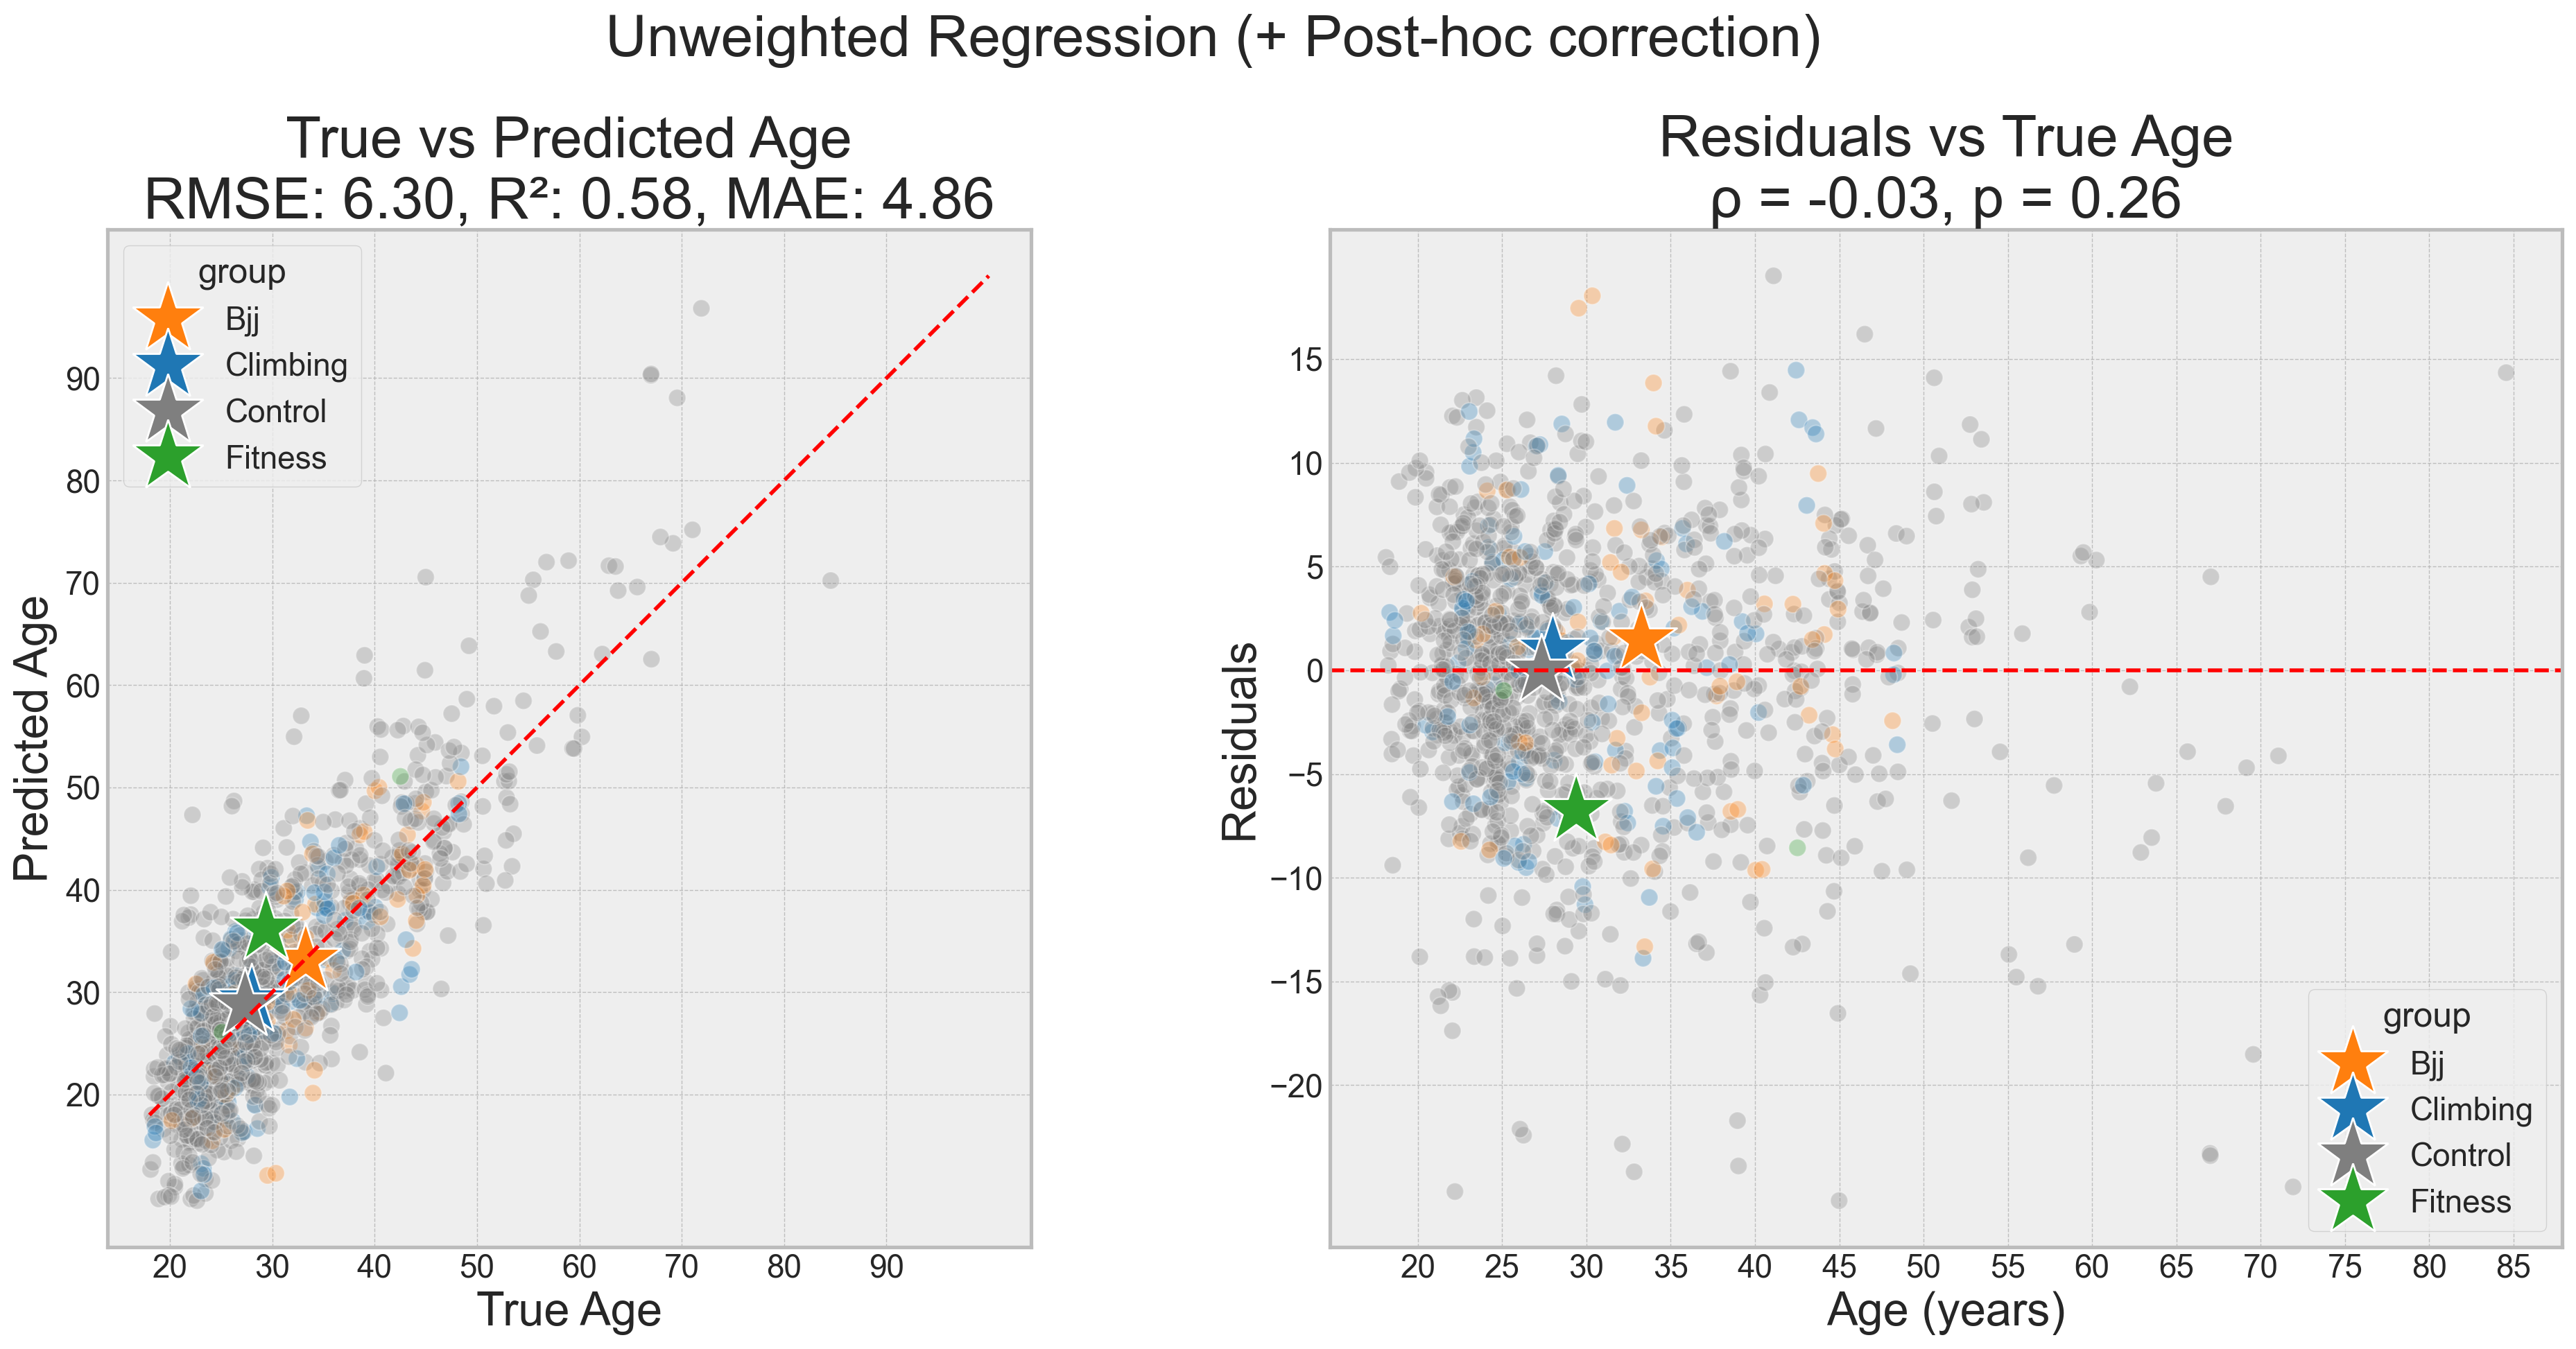

In [172]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

plt.style.use("bmh")

df_vis = df_ols.copy()  # filter out rows with NaN in target
df_vis.loc[df_vis["target"] == False, "group"] = "Control"

# map groups to palette
p = {
    "Climbing": "#1f77b4",  # blue
    "Bjj": "#ff7f0e",  # orange
    "Fitness": "#2ca02c",  # green
    "Control": "#7f7f7f",  
}
# df_vis["color"] = df_vis["group"].map({
#     "Climbing": "#1f77b4",  # blue
#     "Bjj": "#ff7f0e",  # orange
#     "Fitness": "#2ca02c",  # green
#     "Control": "#7f7f7f",  
# }).astype(str)
# colors = df_vis["color"].astype(str).to_list()

do_post_hoc_correction = True
use_weights = False

r2 = r2_score(y, y_pred, sample_weight=w if use_weights else None)
rmse = root_mean_squared_error(y, y_pred, sample_weight=w if use_weights else None)
mae = mean_absolute_error(y, y_pred, sample_weight=w if use_weights else None)

# r2 = r2_score(y, y_pred)
# rmse = root_mean_squared_error(y, y_pred)
# mae = mean_absolute_error(y, y_pred)


# title = f"True vs Predicted Age\nRMSE: {rmse:.2f}, R2: {r2:.2f}, MAE: {mae:.2f}"
title = f"True vs Predicted Age\nRMSE: {rmse:.2f}, R²: {r2:.2f}, MAE: {mae:.2f}"

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# plot true vs predicted
ax = axes[0]
sns.scatterplot(
    data=df_vis,
    x="age",
    y="predicted",
    ax=ax,
    # cmap="jet",
    # color by weight,
    # hue=w.flatten(),
    palette=p,
    hue="group",
    alpha=0.3,
    # use colors from the "color" column
    # hue=df_vis["color"],
    # c=colors,
    # s=w * 10,
    # dont show legend
    legend=False,
)
ax.plot([18, 100], [18, 100], "--", c="red")
ax.set_xlabel("True Age", fontsize=24)
ax.set_ylabel("Predicted Age", fontsize=24)
ax.set_title(title, fontsize=30)
ax.set_xticks(range(20, 100, 10))
ax.set_yticks(range(20, 100, 10))
# make axis square
ax.set_aspect("equal", "box")

# add scatter of the mean predicted age per group
mean_predicted = df_vis.groupby("group")[["age","predicted"]].median().reset_index()
sns.scatterplot(
    data=mean_predicted,
    x="age",
    y="predicted",
    ax=ax,
    s=1500,
    # label="Mean Predicted Age",
    hue="group",
    palette=p,
    marker="*",
    linewidth=1
    
)
# plot residuals vs true age

r, pval = spearmanr(df_vis["age"], df_vis["residuals"])

ax = axes[1]
sns.scatterplot(
    data=df_vis,
    x="age",
    y="residuals",
    ax=ax,
    # cmap="jet",
    # color by weight,
    # hue=w.flatten(),
    # palette="tab10",
    hue="group",
    alpha=0.3,
    palette=p,
    legend=False
    # s=w * 10,
)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("Age (years)", fontsize=24)
ax.set_ylabel("Residuals", fontsize=24)
ax.set_title("Residuals vs True Age\nρ = {:.2f}, p = {:.2g}".format(r, pval), fontsize=30)
ax.set_xticks(range(20, 100, 5))
ax.set_yticks(range(-20, 20, 5))

# add scatter of the mean residuals per group
mean_residuals = df_vis.groupby("group")[["age","residuals"]].median().reset_index()
sns.scatterplot(
    data=mean_residuals,
    x="age",
    y="residuals",
    ax=ax,
    s=1500,
    # label="Mean Residuals",
    hue="group",
    palette=p,
    marker="*",
    linewidth=1
)
# make axis square

suptitle = "Weighted Regression" if use_weights else "Unweighted Regression"
if do_post_hoc_correction:
    suptitle += " (+ Post-hoc correction)"
fig.suptitle(suptitle, fontsize=30)

plt.tight_layout()

(-30.0, 30.0)

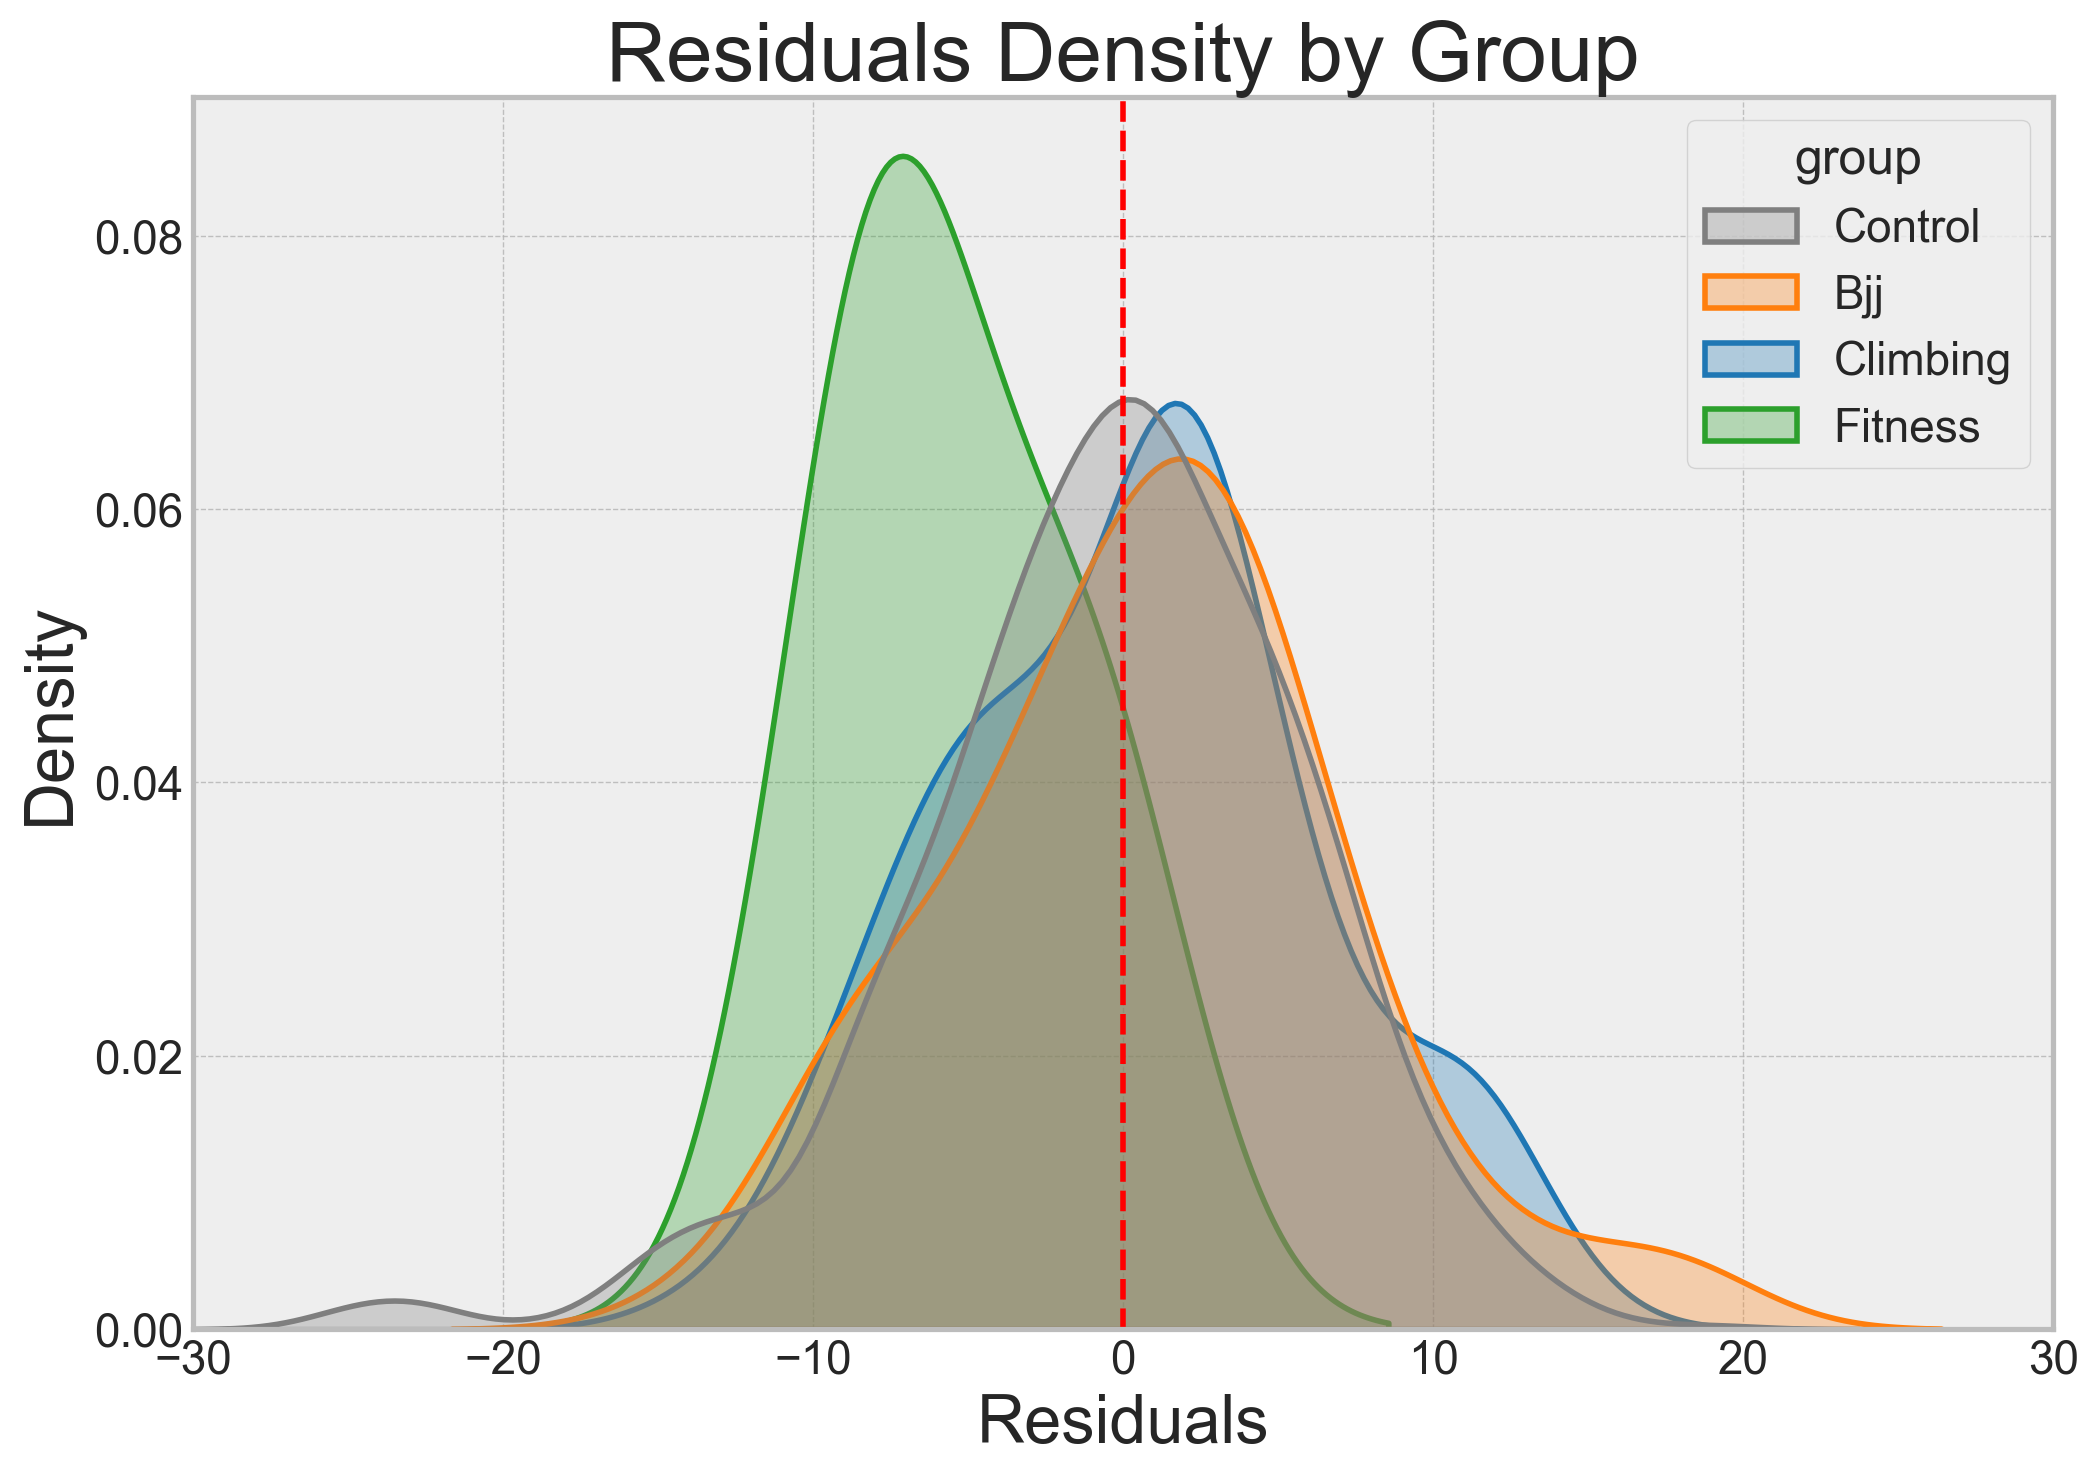

In [175]:
ax = sns.kdeplot(
    data=df_vis,
    x="residuals",
    hue="group",
    common_norm=False,
    fill=True,
    alpha=0.3,
    palette=p,
    linewidth=2,
    # legend=False
)
ax.set_xlabel("Residuals", fontsize=24)
ax.set_ylabel("Density", fontsize=24)
ax.set_title("Residuals Density by Group", fontsize=30)
ax.axvline(0, color="red", linestyle="--")
ax.set_xlim(-30, 30)


In [ ]:
df.loc[df["target"] == True,"residuals"].mean(), df.loc[df["target"] == False,"residuals"].mean()

(np.float64(-1.0040709451075795), np.float64(0.340072845850451))